# Transfer Learning across Different Air Pollutants

<b>Highlights:</b> 
<ul>
    <li>Overcoming the problem of training multiple machine/deep learning models from scratch to forecast different air pollutants in the same air monitoring station.</li>
    <li>Generalization across different air pollutants in the same air monitoring station.</li>
    <li>Developing a pre-trained model to forecast PM2.5 concentration levels and re-using the extracted knowledge to forecast other air pollutants (PM10, NO2, SO2, CO, and O3) in the same air monitoring station by fine-tuning with fewer data.</li>
    <li>Highlighting the use of MLP/ANN architecture for time-series forecasting and transfer learning tasks.</li>
</ul>

## Importing Libraries

In [143]:
import pandas as pd
import numpy as np
import math  
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from datetime import datetime
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, TimeDistributed, Layer, Input, GRU, SimpleRNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import shap

In [144]:
# Hide warnings!
import warnings
warnings.filterwarnings("ignore")

In [145]:
# For reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Importing Dataset: Beijing Multi-Site Air-Quality Data Set

In [146]:
# Importing dataset from different stations
df = pd.read_csv("./datasets/Beijing Multi-Site Air-Quality Data Set/PRSA_Data_Aotizhongxin_20130301-20170228.csv")

In [147]:
# Checking the column names in the dataframe
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [148]:
# Generating descriptive statistics of numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No,35064.0,17532.500000,10122.249256,1.0000,8766.75,17532.5,26298.25,35064.0
year,35064.0,2014.662560,1.177213,2013.0000,2014.00,2015.0,2016.00,2017.0
month,35064.0,6.522930,3.448752,1.0000,4.00,7.0,10.00,12.0
day,35064.0,15.729637,8.800218,1.0000,8.00,16.0,23.00,31.0
hour,35064.0,11.500000,6.922285,0.0000,5.75,11.5,17.25,23.0
PM2.5,34139.0,82.773611,82.135694,3.0000,22.00,58.0,114.00,898.0
PM10,34346.0,110.060391,95.223005,2.0000,38.00,87.0,155.00,984.0
SO2,34129.0,17.375901,22.823017,0.2856,3.00,9.0,21.00,341.0
NO2,34041.0,59.305833,37.116200,2.0000,30.00,53.0,82.00,290.0
CO,33288.0,1262.945145,1221.436236,100.0000,500.00,900.0,1500.00,10000.0


In [149]:
# Information about the DataFrame including: index, dtype, columns, non-null values and memory usage.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34139 non-null  float64
 6   PM10     34346 non-null  float64
 7   SO2      34129 non-null  float64
 8   NO2      34041 non-null  float64
 9   CO       33288 non-null  float64
 10  O3       33345 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34983 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [150]:
print("Total number of columns: ", len(df.columns))
print("Total number of lines: ", len(df))

Total number of columns:  18
Total number of lines:  35064


In [151]:
df.shape

(35064, 18)

In [152]:
df.head(10)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
5,6,2013,3,1,5,5.0,5.0,18.0,18.0,400.0,66.0,-2.2,1025.6,-19.6,0.0,N,3.7,Aotizhongxin
6,7,2013,3,1,6,3.0,3.0,18.0,32.0,500.0,50.0,-2.6,1026.5,-19.1,0.0,NNE,2.5,Aotizhongxin
7,8,2013,3,1,7,3.0,6.0,19.0,41.0,500.0,43.0,-1.6,1027.4,-19.1,0.0,NNW,3.8,Aotizhongxin
8,9,2013,3,1,8,3.0,6.0,16.0,43.0,500.0,45.0,0.1,1028.3,-19.2,0.0,NNW,4.1,Aotizhongxin
9,10,2013,3,1,9,3.0,8.0,12.0,28.0,400.0,59.0,1.2,1028.5,-19.3,0.0,N,2.6,Aotizhongxin


In [153]:
df.station.value_counts()

station
Aotizhongxin    35064
Name: count, dtype: int64

In [154]:
df[['PM2.5','PM10','SO2','NO2','CO','O3']].describe().T

,count,mean,std,min,25%,50%,75%,max
PM2.5,34139.0,82.773611,82.135694,3.0000,22.0,58.0,114.0,898.0
PM10,34346.0,110.060391,95.223005,2.0000,38.0,87.0,155.0,984.0
SO2,34129.0,17.375901,22.823017,0.2856,3.0,9.0,21.0,341.0
NO2,34041.0,59.305833,37.116200,2.0000,30.0,53.0,82.0,290.0
CO,33288.0,1262.945145,1221.436236,100.0000,500.0,900.0,1500.0,10000.0
O3,33345.0,56.353358,57.916327,0.2142,8.0,42.0,82.0,423.0


## Exploratory Data Analysis and Data Preprocessing

In [155]:
# Dropping the column "No"
df.drop(columns = 'No', inplace = True)

In [156]:
# Dropping the column "station"
df.drop(columns = 'station', inplace = True)

In [157]:
# Let's add the column DateTime that combines the year + month + day + hour
df.insert(0, 'DateTime', pd.to_datetime(df[["year", "month", "day","hour"]]))

In [158]:
df.sample(5)

,DateTime,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
6070,2013-11-08 22:00:00,2013,11,8,22,162.0,198.0,88.0,110.0,3200.0,NaN,4.4,1015.5,1.8,0.0,ESE,0.1
32600,2016-11-18 08:00:00,2016,11,18,8,175.0,240.0,11.0,85.0,3900.0,2.0,6.6,1012.1,2.9,0.0,NE,1.5
8846,2014-03-04 14:00:00,2014,3,4,14,7.0,22.0,7.0,9.0,400.0,78.0,9.3,1019.5,-19.8,0.0,WNW,3.9
1483,2013-05-01 19:00:00,2013,5,1,19,39.0,116.0,17.0,28.0,500.0,NaN,19.3,1006.6,1.3,0.0,SW,3.1
4219,2013-08-23 19:00:00,2013,8,23,19,18.0,49.0,3.0,64.0,500.0,89.0,25.7,1003.2,17.1,0.0,SW,0.7


### Data Cleaning

#### Handling Missing Values

In [159]:
# Inspecting missing values NaN
nan_col_vals = pd.DataFrame(columns = ['Null Ratio'], data = df.isnull().sum())
print(nan_col_vals)

          Null Ratio
DateTime           0
year               0
month              0
day                0
hour               0
PM2.5            925
PM10             718
SO2              935
NO2             1023
CO              1776
O3              1719
TEMP              20
PRES              20
DEWP              20
RAIN              20
wd                81
WSPM              14


In [160]:
# Getting the ratio of nan values for each column
nan_col_vals = (nan_col_vals / len(df)) * 100

In [161]:
nan_col_vals = nan_col_vals.loc[nan_col_vals['Null Ratio'] != 0]

In [162]:
nan_col_vals

,Null Ratio
PM2.5,2.638033
PM10,2.047684
SO2,2.666553
NO2,2.917522
CO,5.065024
O3,4.902464
TEMP,0.057039
PRES,0.057039
DEWP,0.057039
RAIN,0.057039


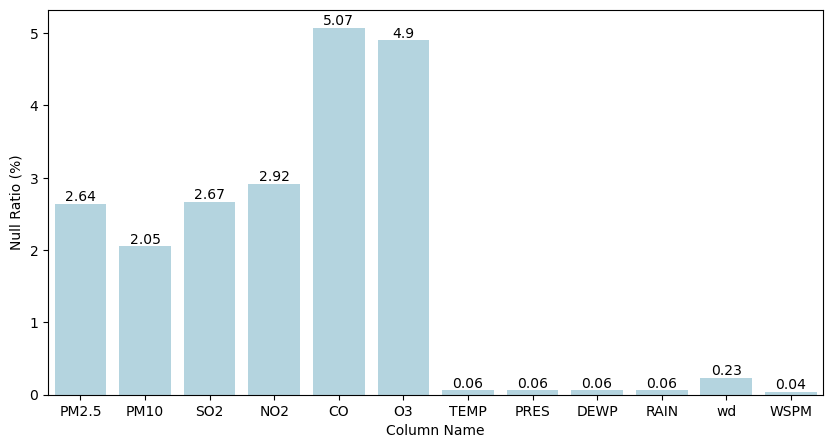

In [163]:
# Plotting the ratio of nan values for each column
# Setting figure size
plt.figure(figsize=(10,5))
# Plotting the barplot using seaborn
ax = sns.barplot(x = nan_col_vals.index, y = round(nan_col_vals['Null Ratio'], 2), color = 'lightblue')
# Setting the labels for each bar plot
ax.bar_label(ax.containers[0])
plt.xlabel("Column Name")
plt.ylabel("Null Ratio (%)")
#plt.savefig("missing_values_ratio.pdf")
plt.show()

##### Column: PM2.5

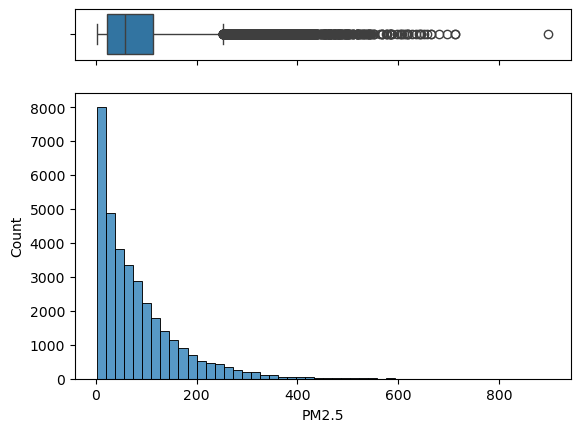

In [164]:
# Handling NaN values in PM2.5 column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["PM2.5"], ax=ax_box)
sns.histplot(x = df["PM2.5"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [165]:
df['PM2.5'].describe()

count    34139.000000
mean        82.773611
std         82.135694
min          3.000000
25%         22.000000
50%         58.000000
75%        114.000000
max        898.000000
Name: PM2.5, dtype: float64

In [166]:
np.nanmedian(df['PM2.5'])

58.0

##### Column: PM10

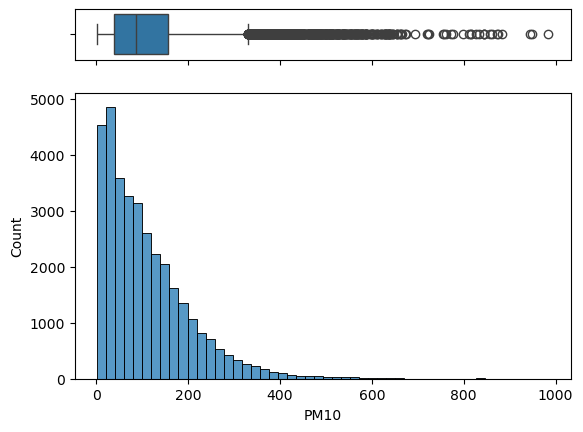

In [167]:
# Handling NaN values in PM10 column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["PM10"], ax=ax_box)
sns.histplot(x = df["PM10"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [168]:
df['PM10'].describe()

count    34346.000000
mean       110.060391
std         95.223005
min          2.000000
25%         38.000000
50%         87.000000
75%        155.000000
max        984.000000
Name: PM10, dtype: float64

In [169]:
np.nanmedian(df['PM10'])

87.0

##### Column: SO2

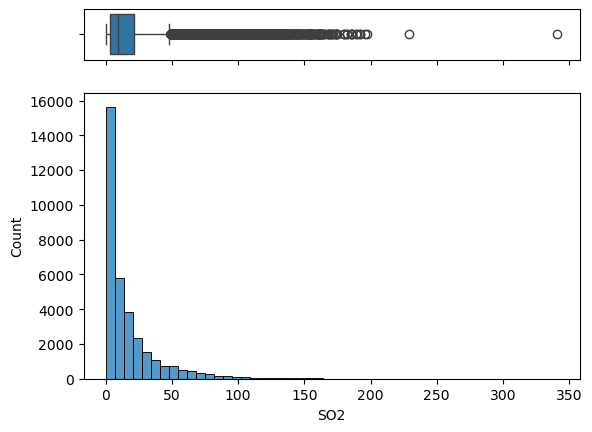

In [170]:
# Handling NaN values in SO2 column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["SO2"], ax=ax_box)
sns.histplot(x = df["SO2"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [171]:
df['SO2'].describe()

count    34129.000000
mean        17.375901
std         22.823017
min          0.285600
25%          3.000000
50%          9.000000
75%         21.000000
max        341.000000
Name: SO2, dtype: float64

In [172]:
np.nanmedian(df['SO2'])

9.0

##### Column: NO2

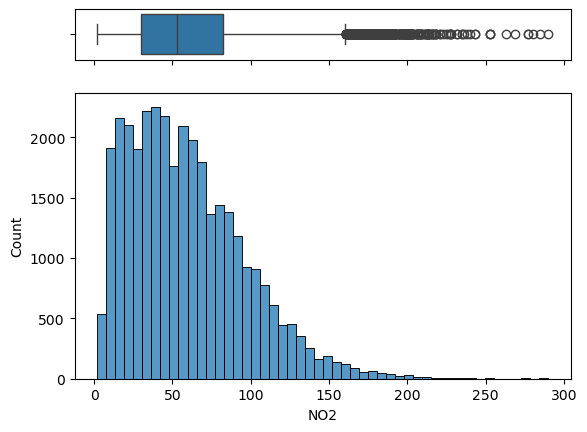

In [173]:
# Handling NaN values in NO2 column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["NO2"], ax=ax_box)
sns.histplot(x = df["NO2"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [174]:
df['NO2'].describe()

count    34041.000000
mean        59.305833
std         37.116200
min          2.000000
25%         30.000000
50%         53.000000
75%         82.000000
max        290.000000
Name: NO2, dtype: float64

In [175]:
np.nanmedian(df['NO2'])

53.0

##### Column: CO

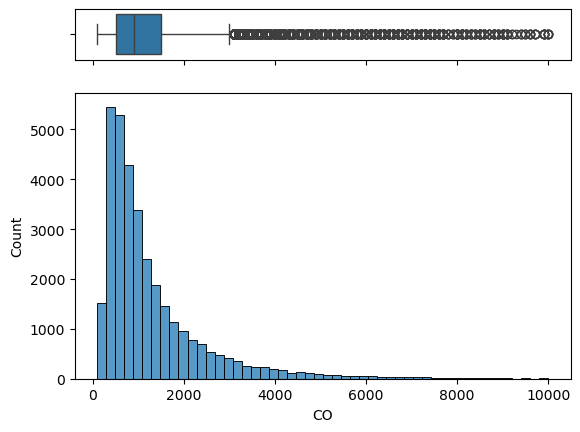

In [176]:
# Handling NaN values in CO column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["CO"], ax=ax_box)
sns.histplot(x = df["CO"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [177]:
df['CO'].describe()

count    33288.000000
mean      1262.945145
std       1221.436236
min        100.000000
25%        500.000000
50%        900.000000
75%       1500.000000
max      10000.000000
Name: CO, dtype: float64

In [178]:
np.nanmedian(df['CO'])

900.0

##### Column: O3

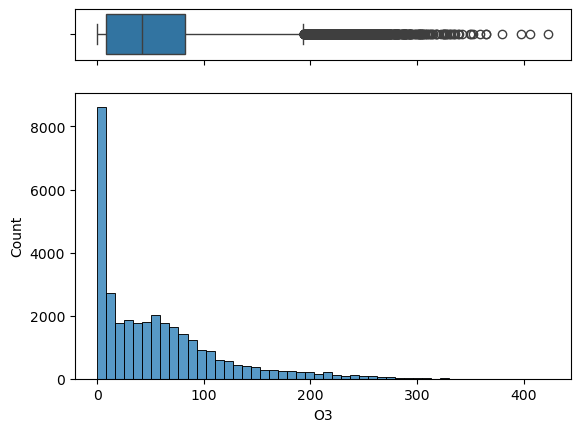

In [179]:
# Handling NaN values in O3 column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["O3"], ax=ax_box)
sns.histplot(x = df["O3"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [180]:
df['O3'].describe()

count    33345.000000
mean        56.353358
std         57.916327
min          0.214200
25%          8.000000
50%         42.000000
75%         82.000000
max        423.000000
Name: O3, dtype: float64

In [181]:
np.nanmedian(df['O3'])

42.0

##### Column: TEMP

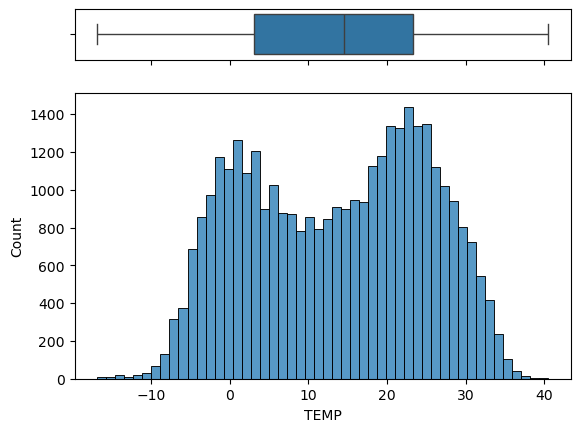

In [182]:
# Handling NaN values in TEMP column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["TEMP"], ax=ax_box)
sns.histplot(x = df["TEMP"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [183]:
df['TEMP'].describe()

count    35044.000000
mean        13.584607
std         11.399097
min        -16.800000
25%          3.100000
50%         14.500000
75%         23.300000
max         40.500000
Name: TEMP, dtype: float64

In [184]:
np.nanmedian(df['TEMP'])

14.5

##### Column: PRES

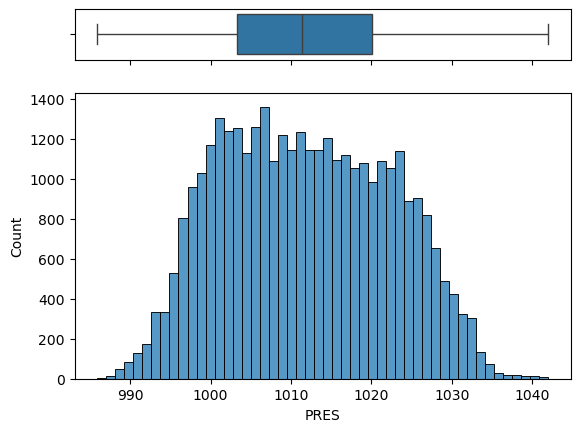

In [185]:
# Handling NaN values in PRES column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["PRES"], ax=ax_box)
sns.histplot(x = df["PRES"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [186]:
df['PRES'].describe()

count    35044.000000
mean      1011.846920
std         10.404047
min        985.900000
25%       1003.300000
50%       1011.400000
75%       1020.100000
max       1042.000000
Name: PRES, dtype: float64

In [187]:
np.nanmedian(df['PRES'])

1011.4

##### Column: DEWP

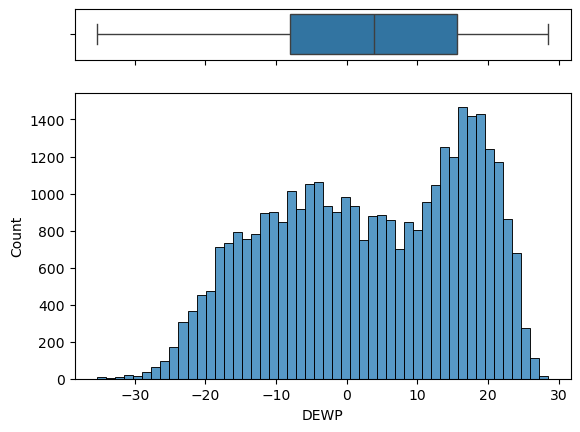

In [188]:
# Handling NaN values in DEWP column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["DEWP"], ax=ax_box)
sns.histplot(x = df["DEWP"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [189]:
df['DEWP'].describe()

count    35044.000000
mean         3.123062
std         13.688896
min        -35.300000
25%         -8.100000
50%          3.800000
75%         15.600000
max         28.500000
Name: DEWP, dtype: float64

In [190]:
np.nanmedian(df['DEWP'])

3.8

##### Column: RAIN

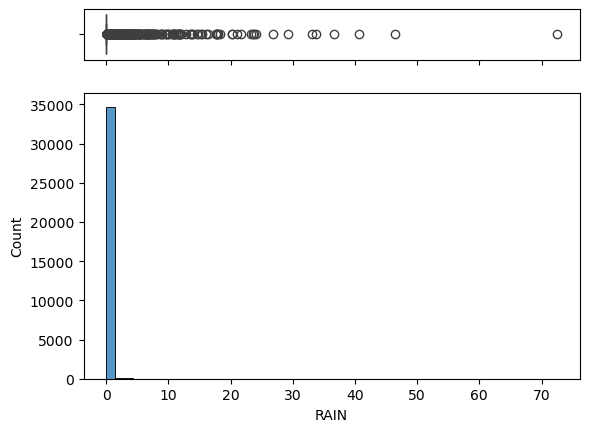

In [191]:
# Handling NaN values in RAIN column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["RAIN"], ax=ax_box)
sns.histplot(x = df["RAIN"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [192]:
df['RAIN'].describe()

count    35044.000000
mean         0.067421
std          0.910056
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         72.500000
Name: RAIN, dtype: float64

In [193]:
np.nanmedian(df['RAIN'])

0.0

##### Column: WSPM

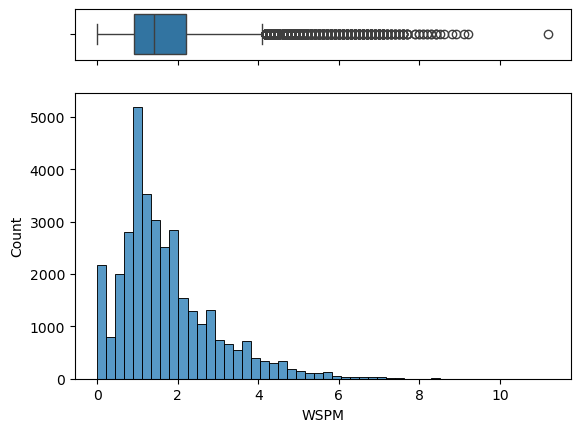

In [194]:
# Handling NaN values in WSPM column
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(x = df["WSPM"], ax=ax_box)
sns.histplot(x = df["WSPM"], ax=ax_hist, bins = 50)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Show the plot
plt.show()

In [195]:
df['WSPM'].describe()

count    35050.000000
mean         1.708496
std          1.204071
min          0.000000
25%          0.900000
50%          1.400000
75%          2.200000
max         11.200000
Name: WSPM, dtype: float64

In [196]:
np.nanmedian(df['WSPM'])

1.4

##### Column: wd

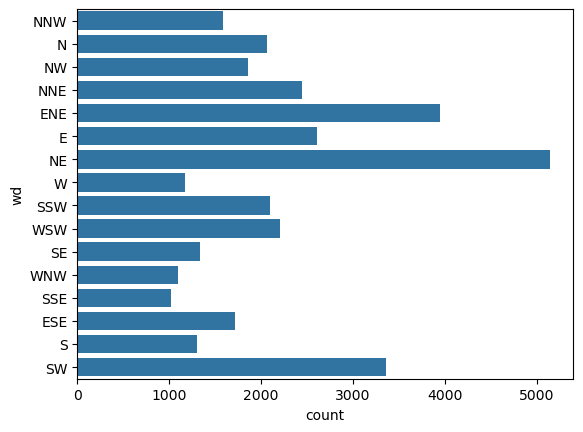

In [197]:
sns.countplot(df.wd)
plt.show()

#### Regression plots with each numerical column (with missing values) and its one-lag value

In [198]:
nan_col_vals.index

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM'],
      dtype='object')

In [199]:
num_nan_cols = df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM']]

In [200]:
num_nan_lagged = num_nan_cols.shift(1)
# Plot regplots for each column and its lagged version
columns_to_plot = list(num_nan_cols.columns)

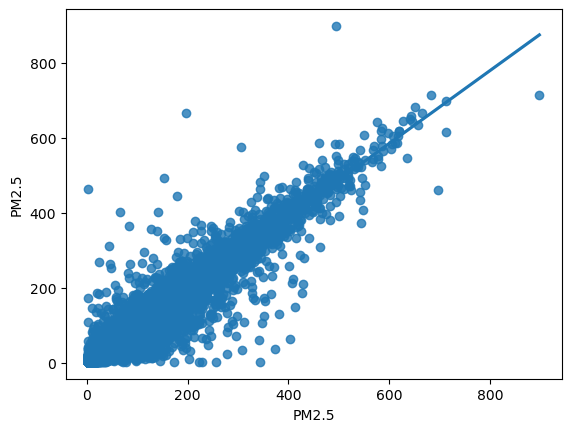

In [201]:
#create regplot
p = sns.regplot(x=num_nan_lagged['PM2.5'], y=num_nan_cols['PM2.5'])

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

# Calculate R-squared
y_pred = slope * num_nan_lagged['PM2.5'] + intercept
r2 = r2_score(num_nan_cols.loc[1:,'PM2.5'].dropna(), y_pred[1:].dropna())

In [202]:
r2

0.9342443551966086

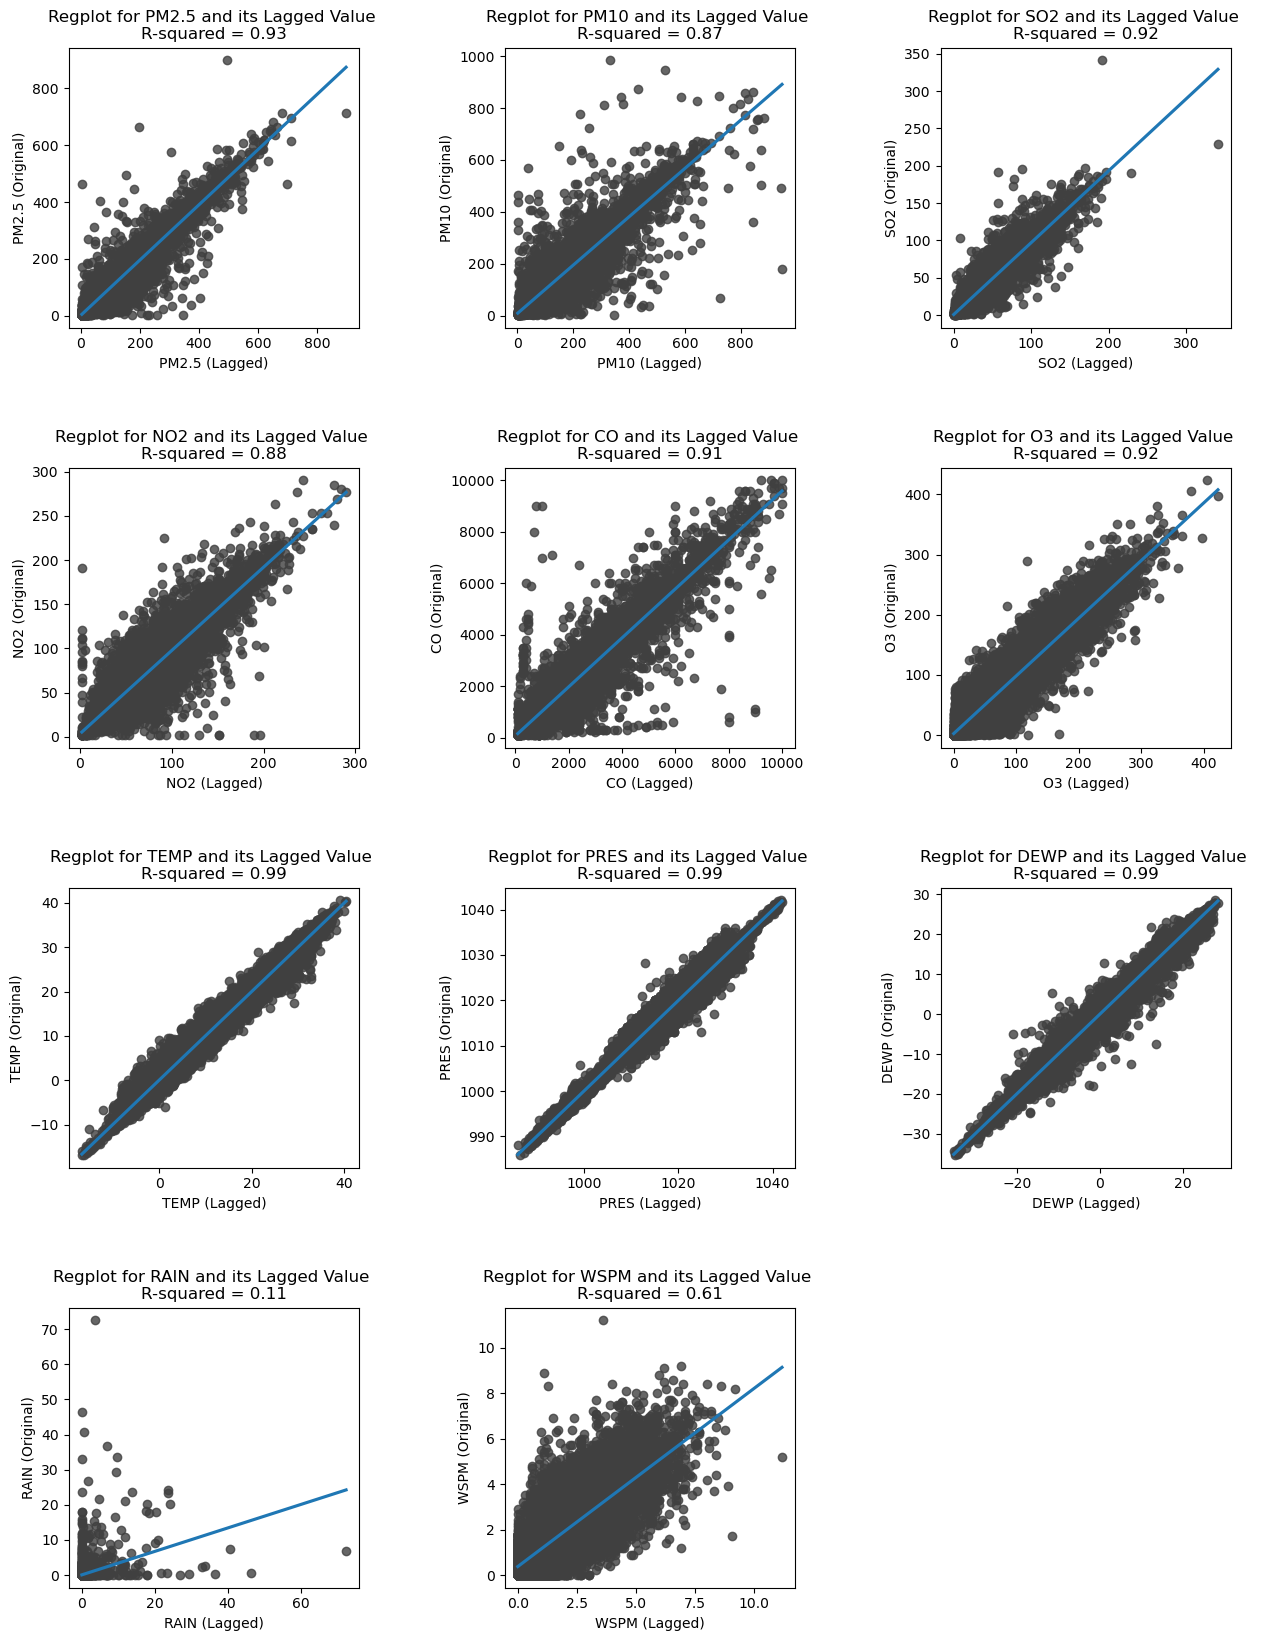

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [203]:
# Set up subplots with 3 plots per row
num_cols = 3
num_rows = len(num_nan_cols.columns) // num_cols + (len(num_nan_cols.columns) % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Adjust space between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, col in enumerate(num_nan_cols.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    
    plt.figure(figsize=(10, 5))
    
    # Scatter plot
    p = sns.regplot(x=num_nan_lagged[col], y=num_nan_cols[col], ci=None, scatter_kws=dict(color='0.25'), ax=axes[row_index, col_index])
    
    #calculate slope and intercept of regression equation
    slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

    # Calculate R-squared
    y_pred = slope * num_nan_lagged[col] + intercept
    r2 = r2_score(num_nan_cols.loc[1:,col].dropna(), y_pred[1:].dropna())
    
    # Annotate the plot with the R-squared value
    axes[row_index, col_index].set_title(f'Regplot for {col} and its Lagged Value \nR-squared = {r2:.2f}')
    axes[row_index, col_index].set_xlabel(f'{col} (Lagged)')
    axes[row_index, col_index].set_ylabel(f'{col} (Original)')

# Remove the empty subplot
fig.delaxes(axes.flatten()[-1])

# Adjust layout
plt.tight_layout()
plt.show()

In [204]:
## Handling NaN values in PM2.5 column
# Perform forward fill
df['PM2.5'].ffill(inplace = True)
# Inspecting the success of the method
print("Total number of NaN values in PM2.5 column:", df.loc[:, 'PM2.5'].isna().sum())

Total number of NaN values in PM2.5 column: 0


Histogram plot and Box plot:  PM10


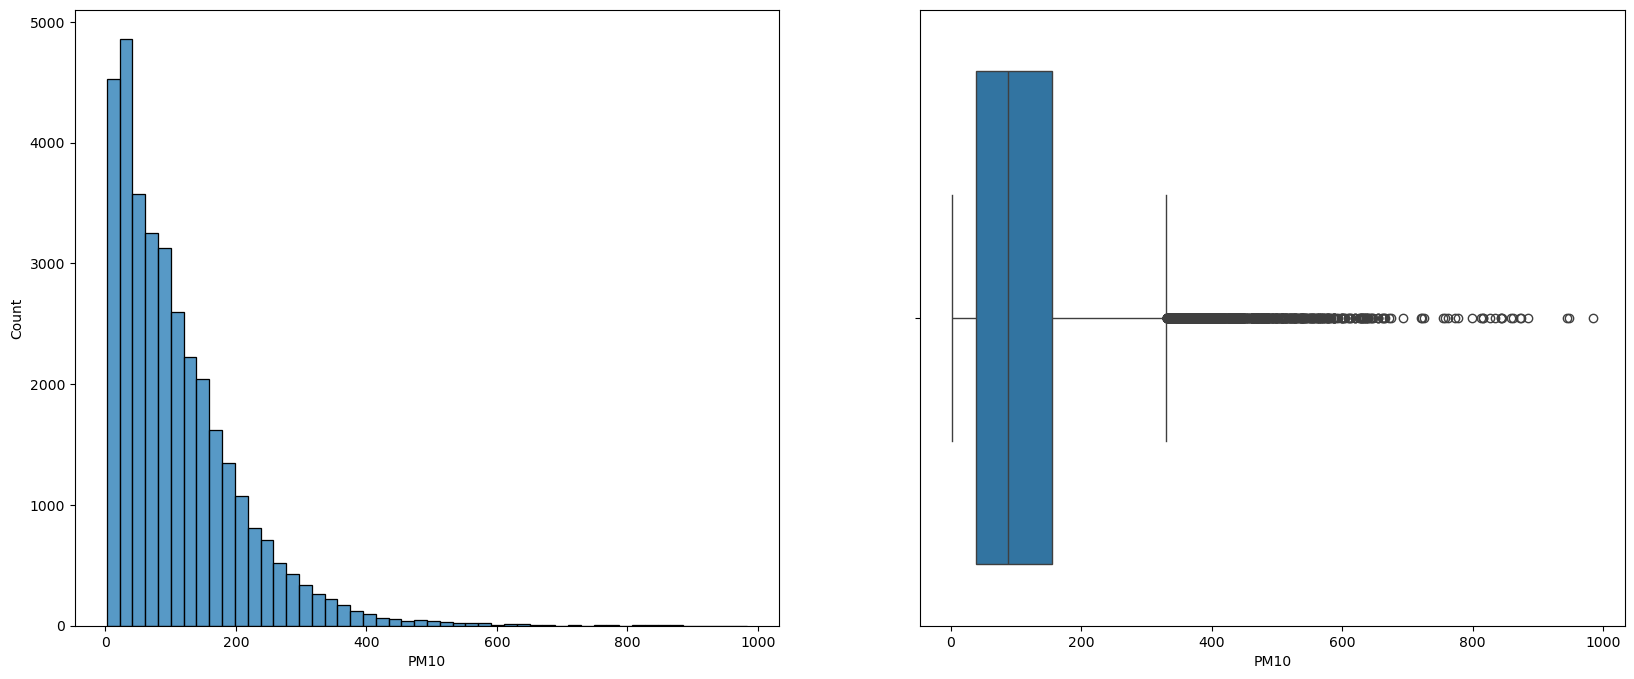

Histogram plot and Box plot:  SO2


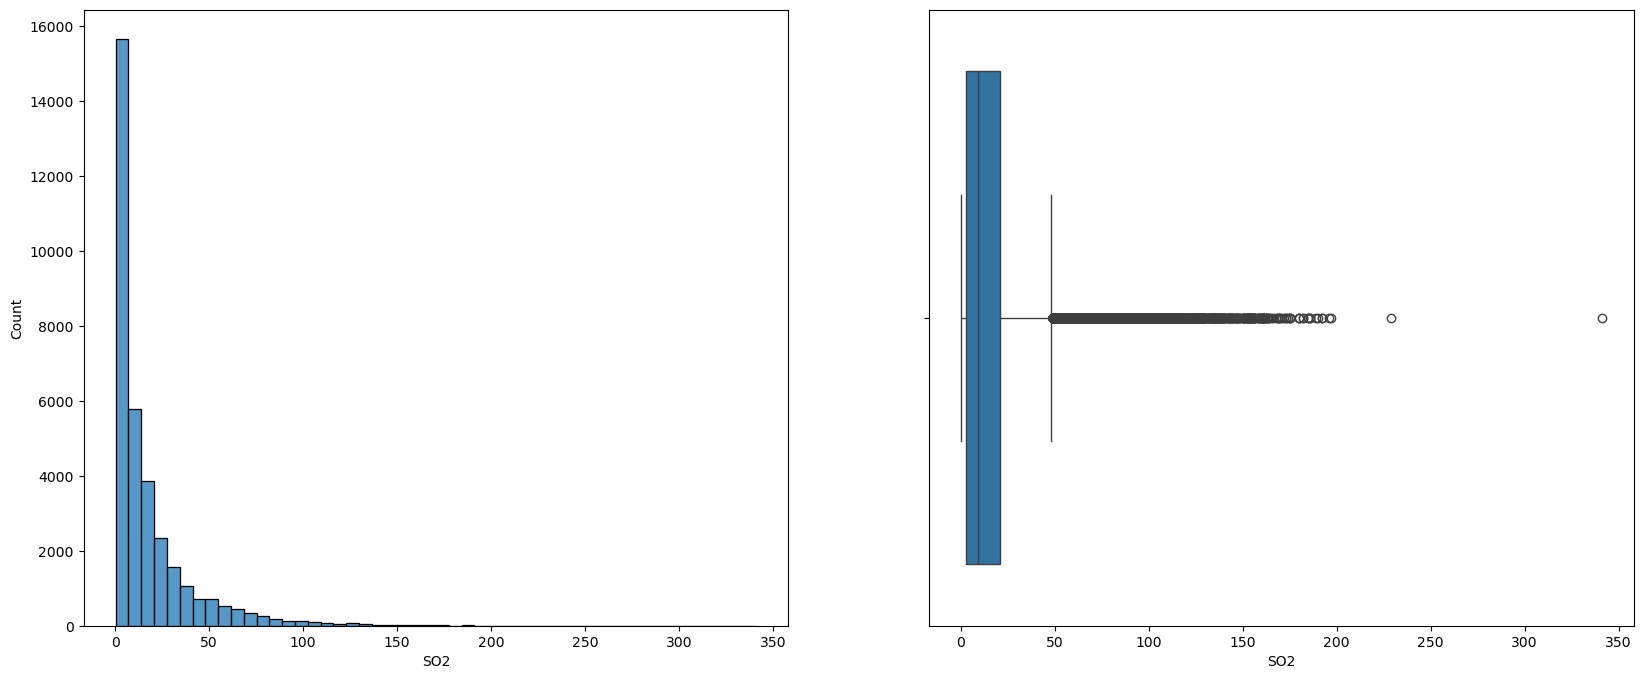

Histogram plot and Box plot:  NO2


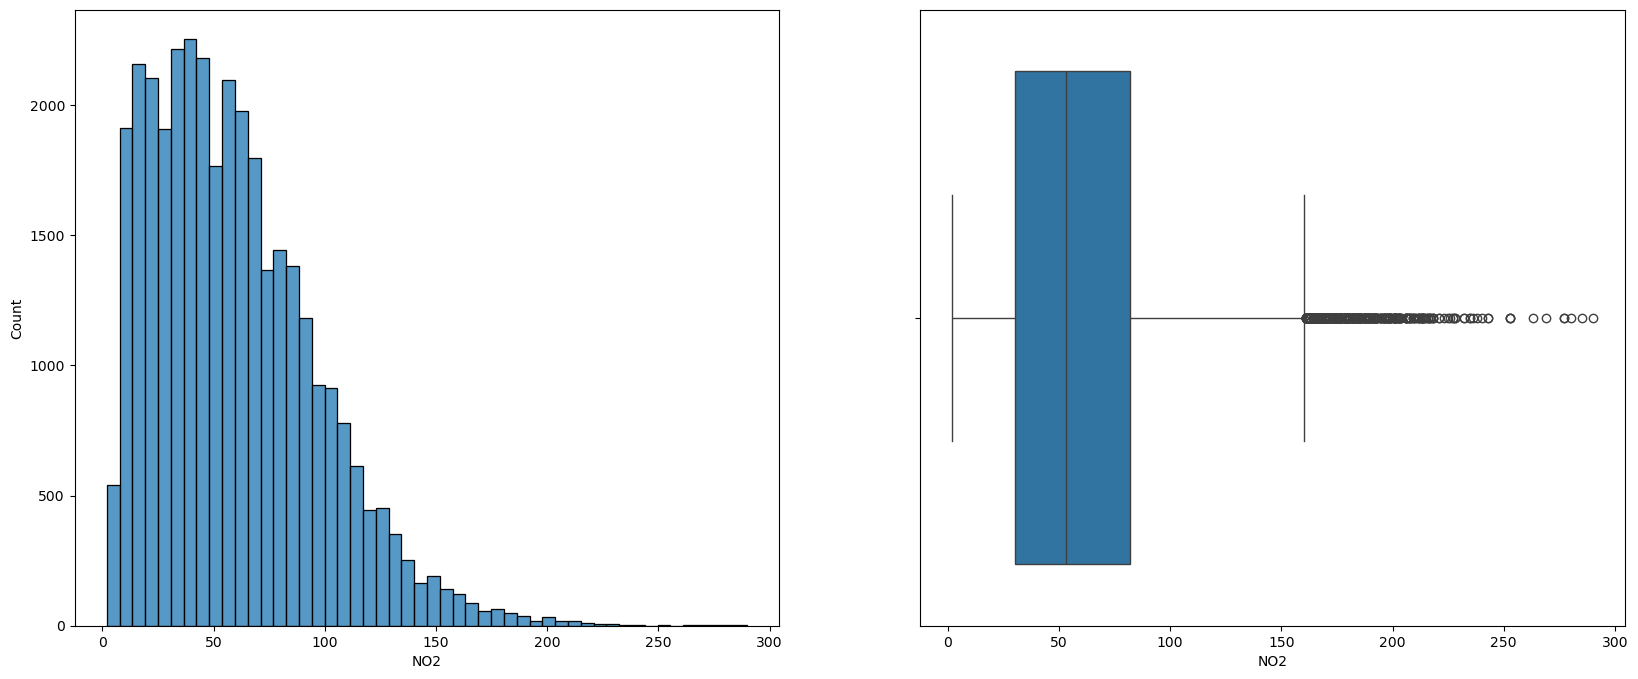

Histogram plot and Box plot:  CO


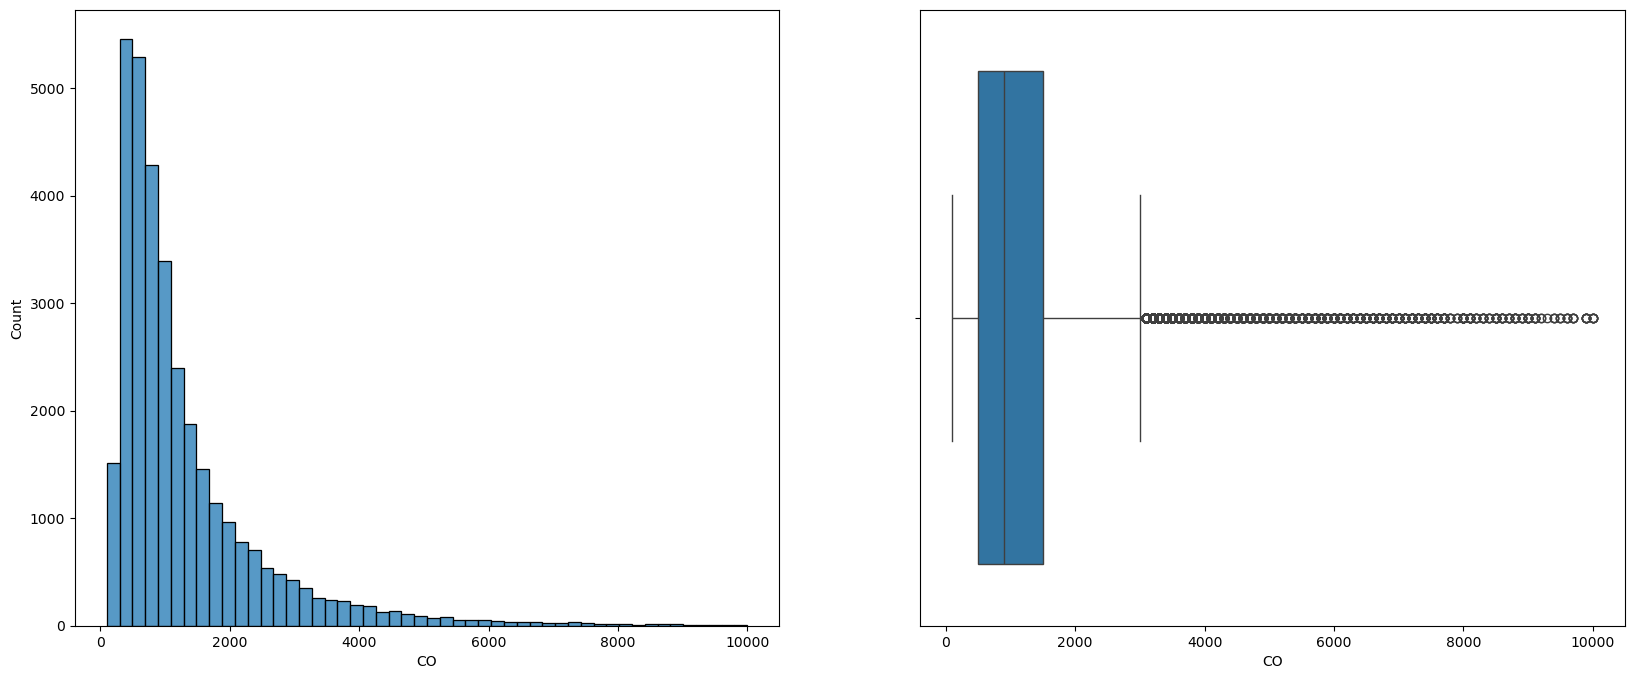

Histogram plot and Box plot:  O3


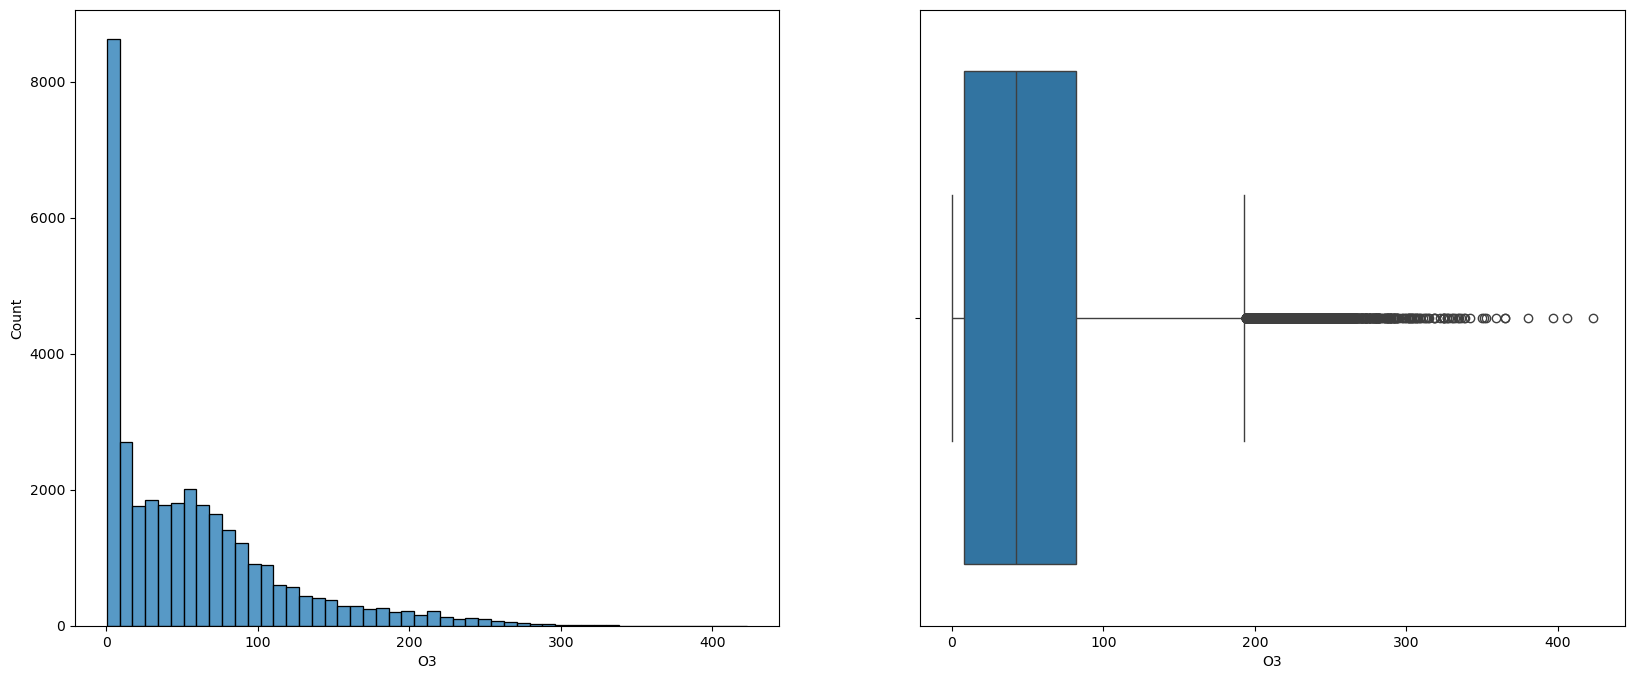

Histogram plot and Box plot:  TEMP


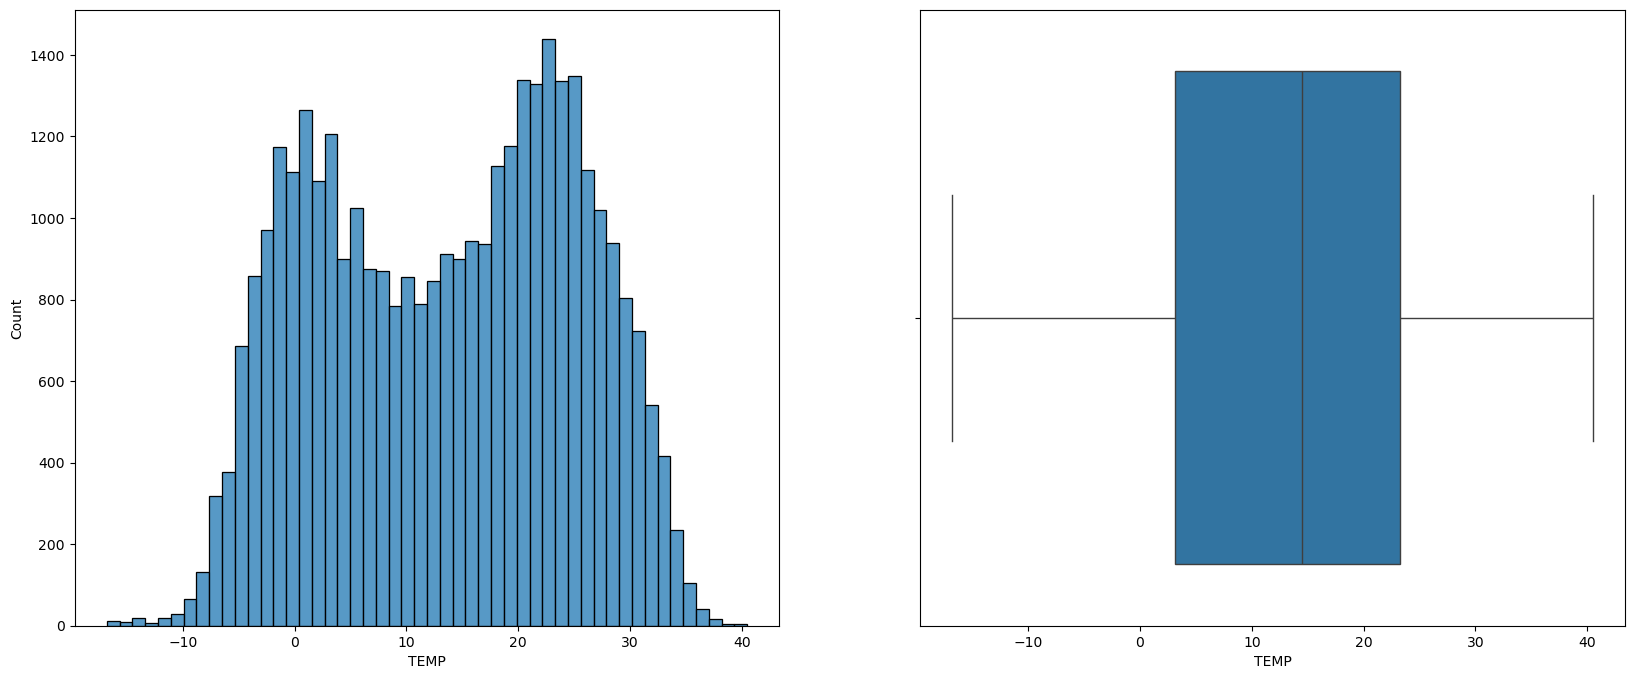

Histogram plot and Box plot:  PRES


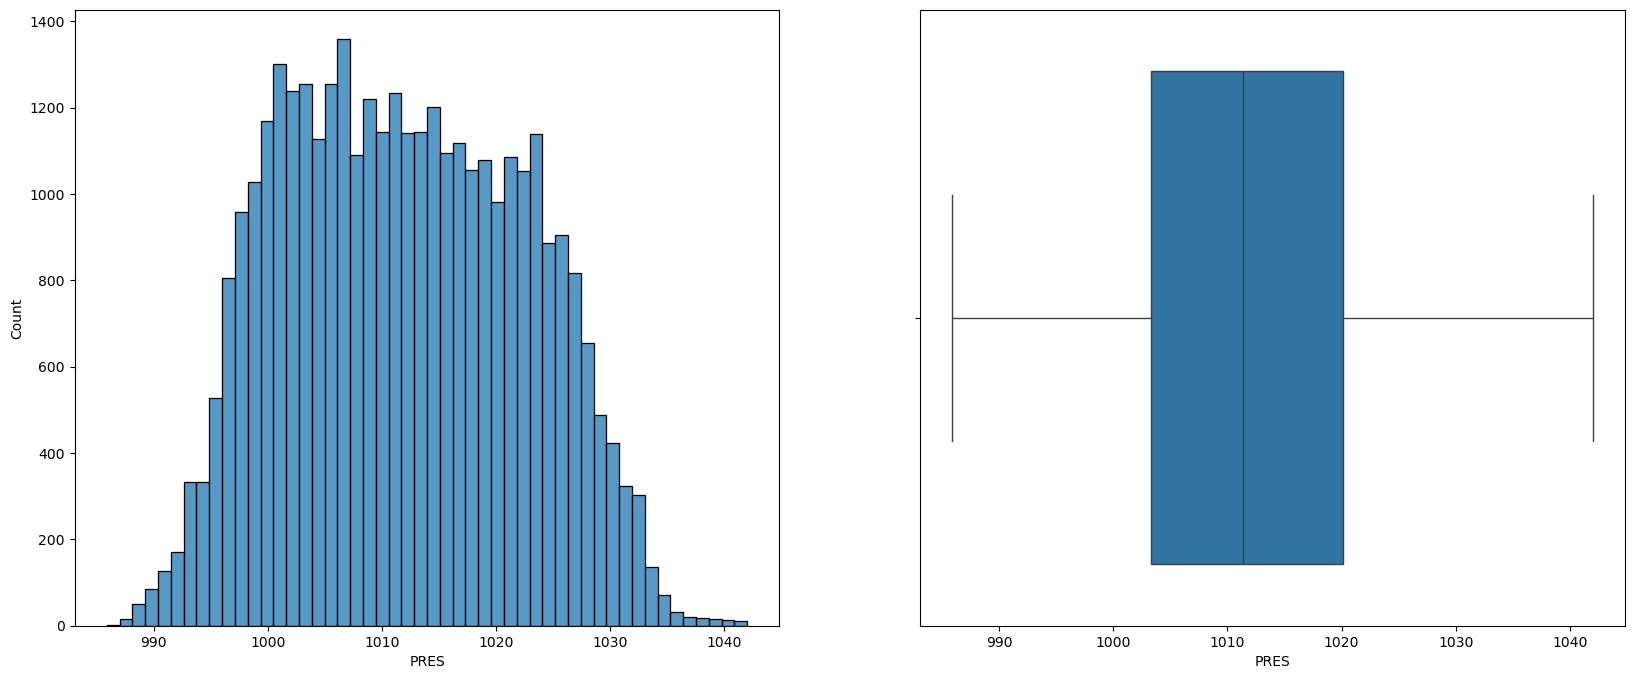

Histogram plot and Box plot:  DEWP


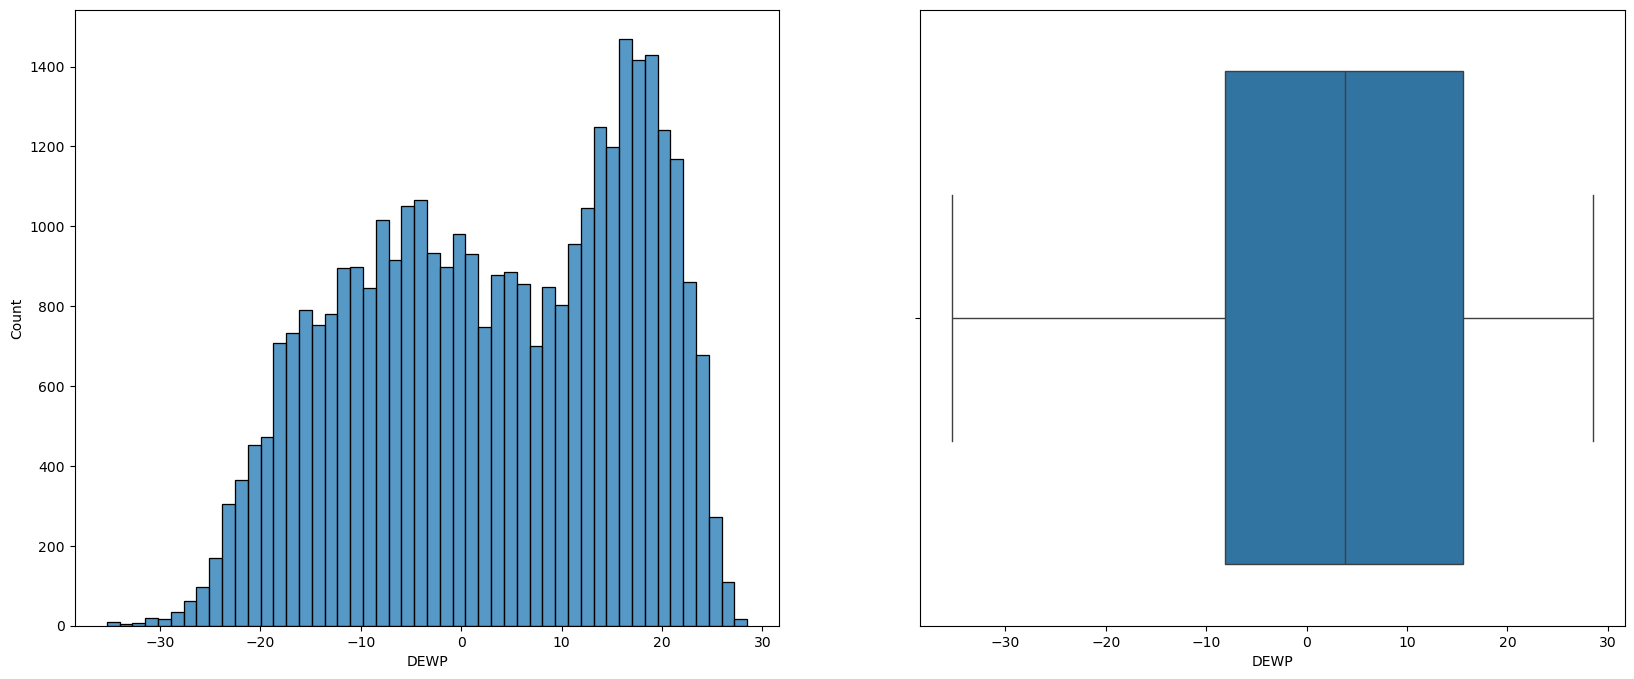

Histogram plot and Box plot:  RAIN


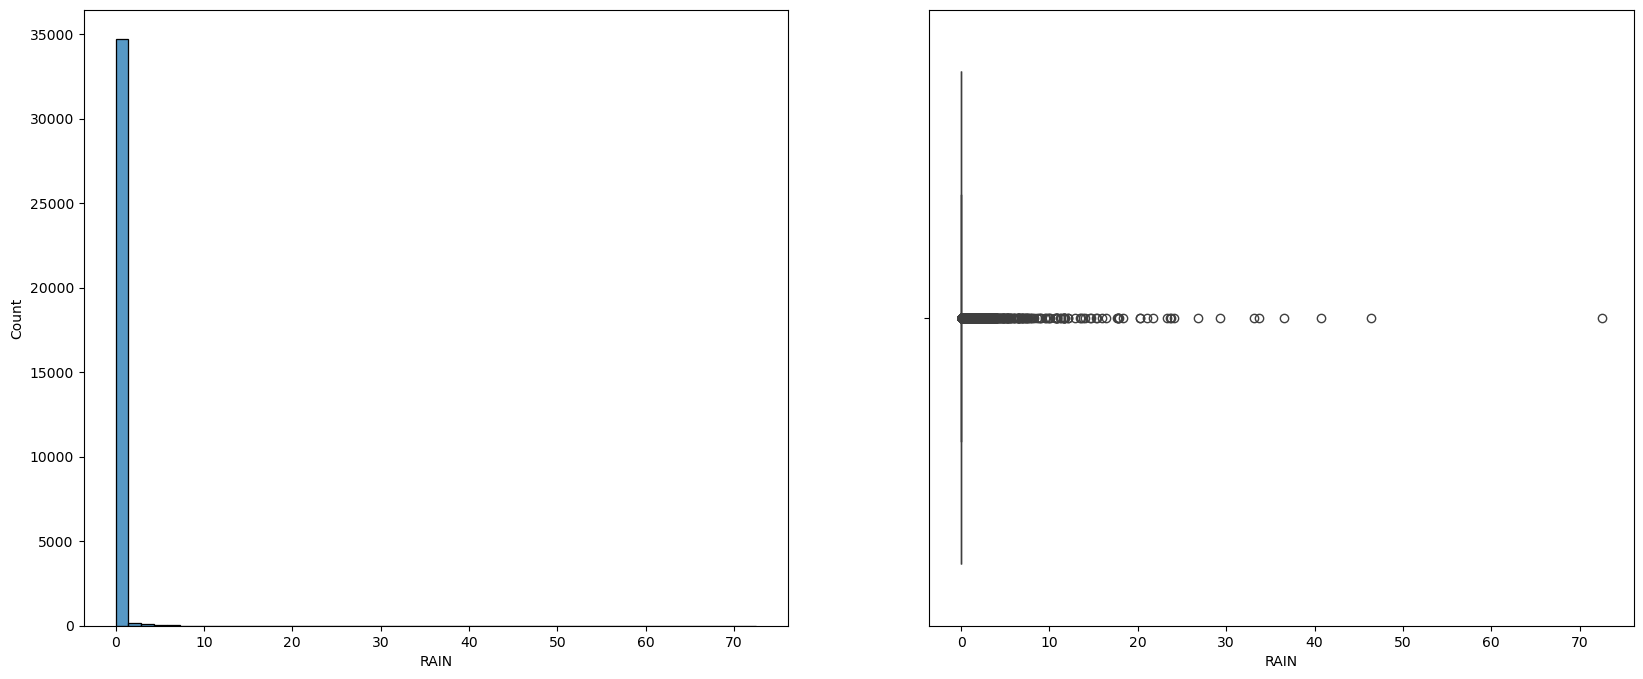

Histogram plot and Box plot:  WSPM


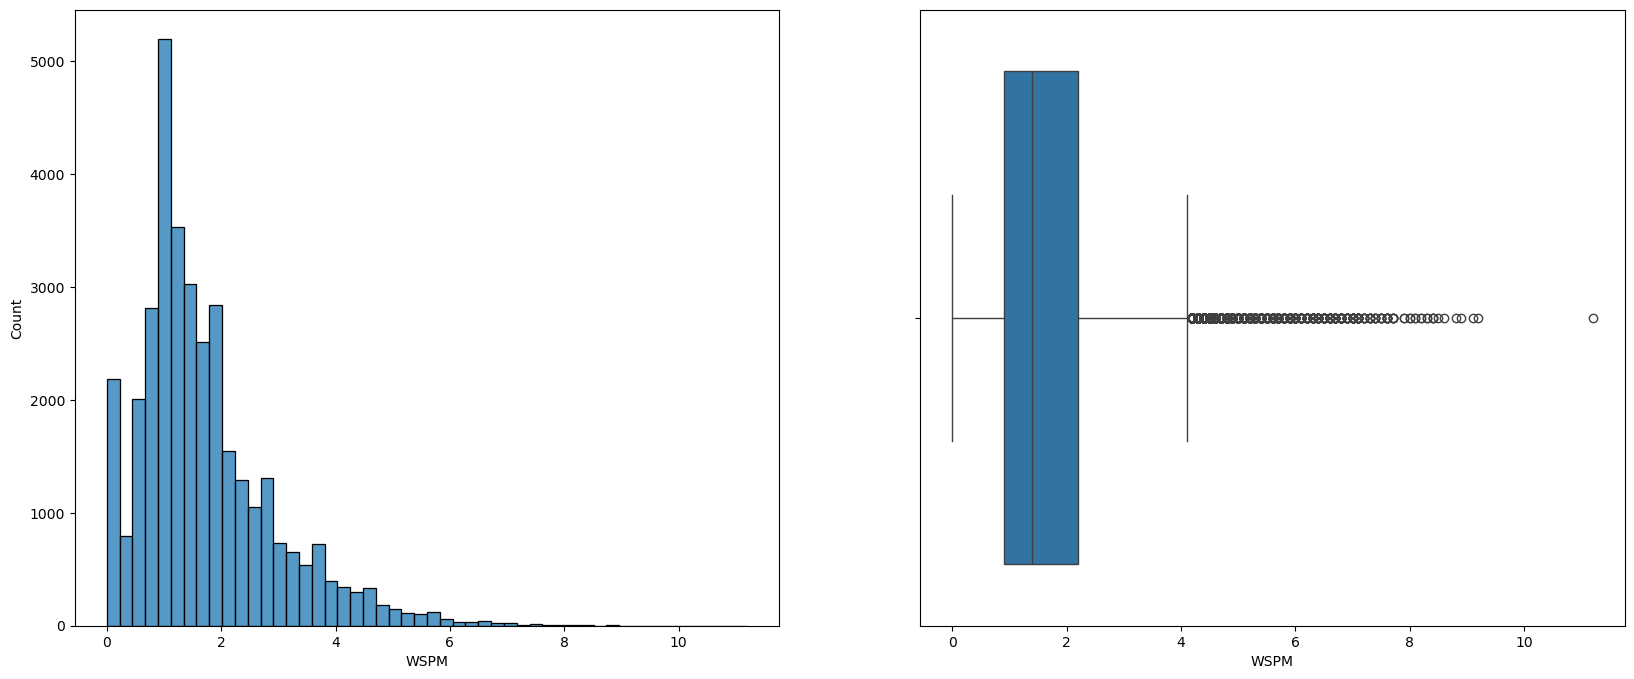

In [205]:
## Missing values for PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WSPM
# List of columns that contain NaN values, note that, I did not include 'wd' column, we will process it later
nan_cols_names = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
# A for loop to create histogram and boxplot plots for each of the columns in 'nan_cols_names'
for col in nan_cols_names:
    print("Histogram plot and Box plot: ", col)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    sns.histplot(df[col], ax=ax1, bins = 50)
    sns.boxplot(x = df[col], ax = ax2)
    plt.show()

In [206]:
## Missing values for PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WD, WSPM
# Perform forward fill
for col in nan_cols_names:
    # Perform forward fill for each column
    df[col].ffill(inplace = True)    
    # Checking the column after nan values imputation
    print("Total rows with NaN values in ", col," after ffill imputation: ",df[col].isnull().sum())

Total rows with NaN values in  PM10  after ffill imputation:  0
Total rows with NaN values in  SO2  after ffill imputation:  0
Total rows with NaN values in  NO2  after ffill imputation:  0
Total rows with NaN values in  CO  after ffill imputation:  0
Total rows with NaN values in  O3  after ffill imputation:  0
Total rows with NaN values in  TEMP  after ffill imputation:  0
Total rows with NaN values in  PRES  after ffill imputation:  0
Total rows with NaN values in  DEWP  after ffill imputation:  0
Total rows with NaN values in  RAIN  after ffill imputation:  0
Total rows with NaN values in  WSPM  after ffill imputation:  0


In [207]:
## Missing values for PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WD, WSPM
# Filling in NaN values in 'wd' column
df.wd.value_counts()

wd
NE     5140
ENE    3950
SW     3359
E      2608
NNE    2445
WSW    2212
SSW    2098
N      2066
NW     1860
ESE    1717
NNW    1589
SE     1341
S      1304
W      1171
WNW    1101
SSE    1022
Name: count, dtype: int64

<AxesSubplot:xlabel='count', ylabel='wd'>

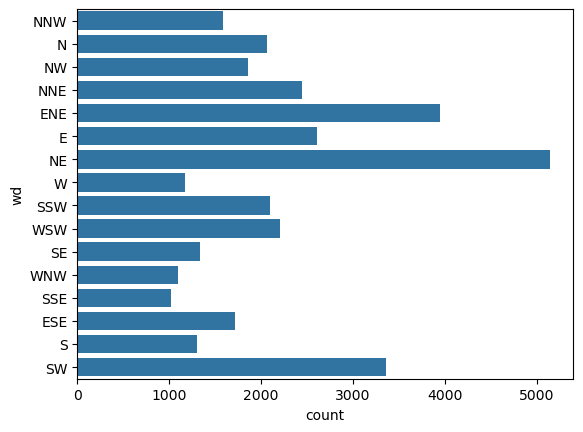

In [208]:
## Missing values for WD
# Plotting column 'wd' values
sns.countplot(df.wd)

In [209]:
## Missing values for PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WD, WSPM
df.loc[(df['wd'].isna())]

,DateTime,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
6388,2013-11-22 04:00:00,2013,11,22,4,82.0,74.0,15.0,75.0,1300.0,4.9266,-3.200,1020.5,-4.0,0.0,NaN,0.1
11718,2014-07-02 06:00:00,2014,7,2,6,44.0,44.0,2.0,16.0,800.0,105.0000,21.500,998.2,21.5,0.1,NaN,0.2
13412,2014-09-10 20:00:00,2014,9,10,20,56.0,141.0,13.0,81.0,700.0,99.0000,21.700,1008.0,15.8,0.0,NaN,0.0
16748,2015-01-27 20:00:00,2015,1,27,20,26.0,42.0,12.0,78.0,1300.0,2.0000,-5.200,1030.5,-21.3,0.0,NaN,0.4
17263,2015-02-18 07:00:00,2015,2,18,7,13.0,14.0,12.0,22.0,600.0,60.0000,0.000,1022.0,-12.3,0.0,NaN,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34314,2017-01-28 18:00:00,2017,1,28,18,246.0,266.0,63.0,82.0,300.0,51.0000,0.625,1016.0,-7.9,0.0,NaN,0.5
34334,2017-01-29 14:00:00,2017,1,29,14,15.0,55.0,4.0,6.0,300.0,80.0000,-1.220,1025.0,-21.6,0.0,NaN,6.5
34560,2017-02-08 00:00:00,2017,2,8,0,113.0,124.0,17.0,105.0,2600.0,2.0000,-2.800,1026.3,-7.0,0.0,NaN,0.2
34638,2017-02-11 06:00:00,2017,2,11,6,15.0,24.0,16.0,71.0,600.0,25.0000,-4.600,1025.0,-18.1,0.0,NaN,0.2


In [210]:
# Filling in the missing values of "wd" with the mode
df['wd'].fillna(value = df.wd.value_counts().index[0], inplace = True)
# Inspecting the success of the method
print("Total number of NaN values in 'wd' column:", df.loc[:,'wd'].isna().sum())

Total number of NaN values in 'wd' column: 0


In [211]:
# Checking the dataframe after handling NaN values
df.isna().sum()

DateTime    0
year        0
month       0
day         0
hour        0
PM2.5       0
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd          0
WSPM        0
dtype: int64

## Additional Exploratory Data Analysis

In [212]:
df.columns

Index(['DateTime', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2',
       'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'],
      dtype='object')

In [213]:
# Defining air pollutants list
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

In [214]:
pollutants

['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

### Yearly Analysis

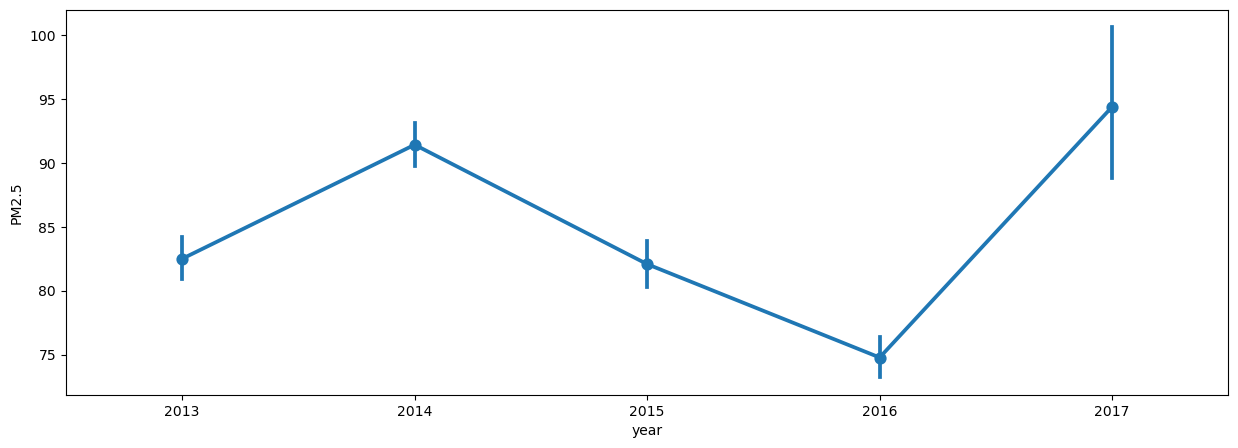

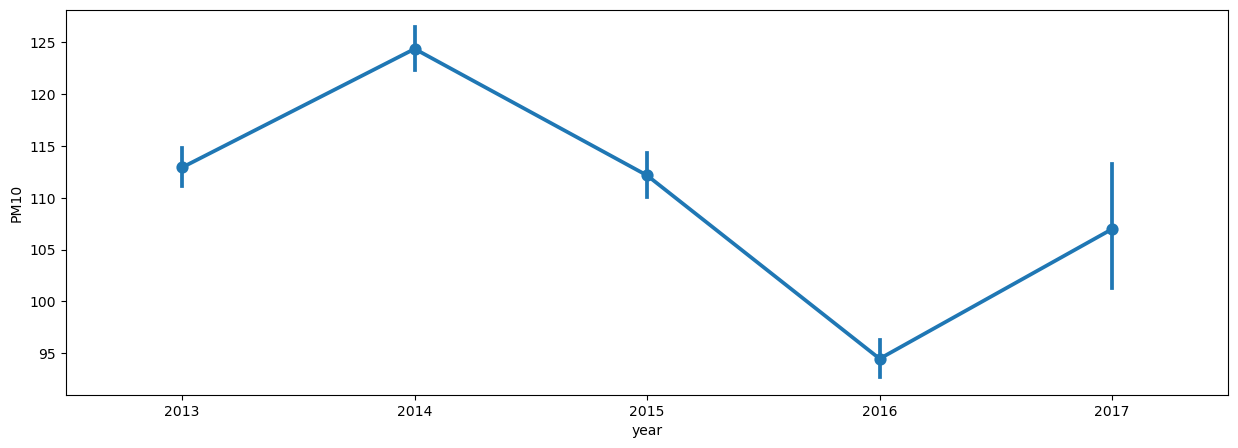

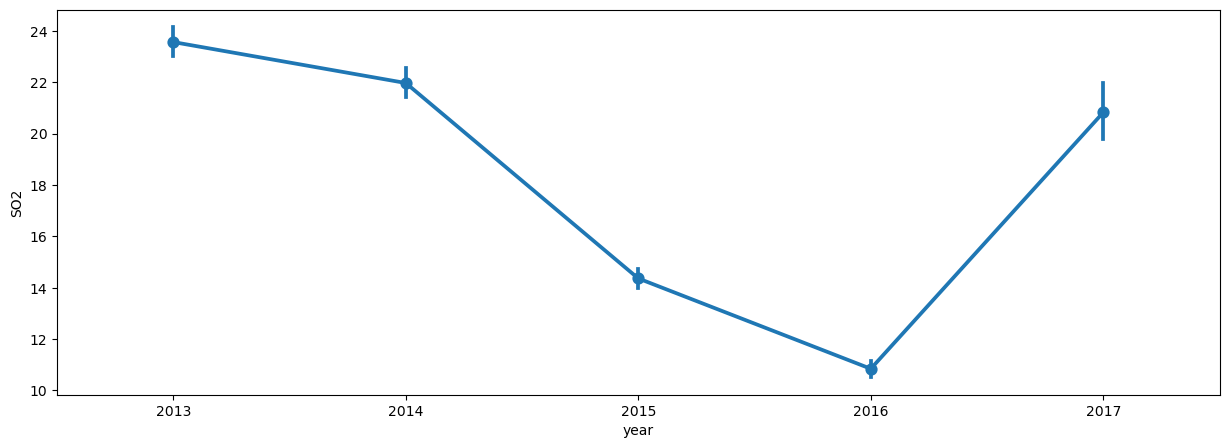

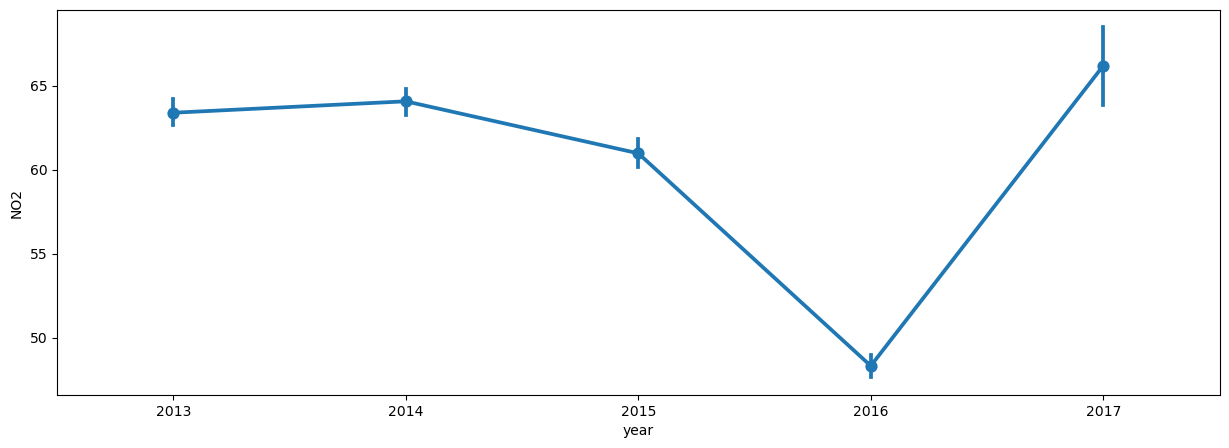

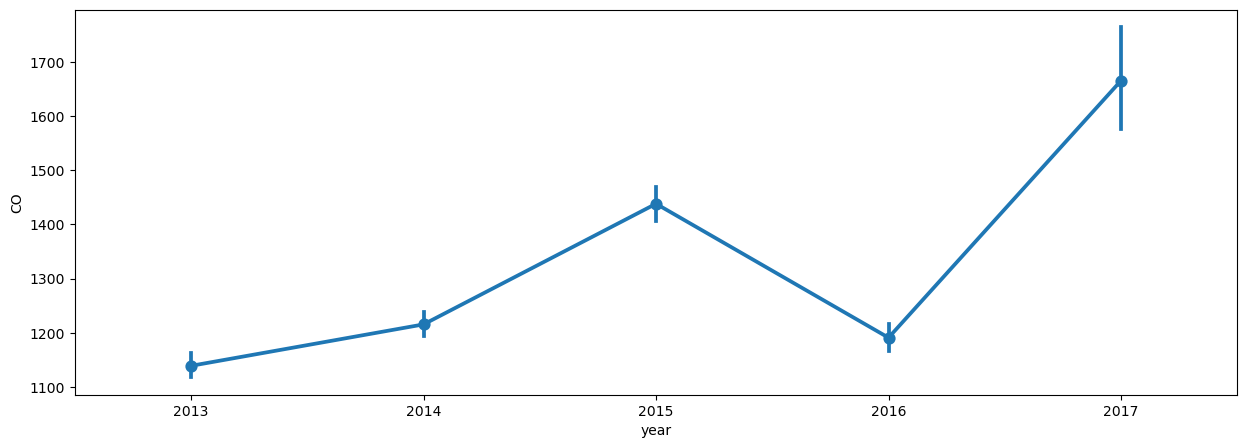

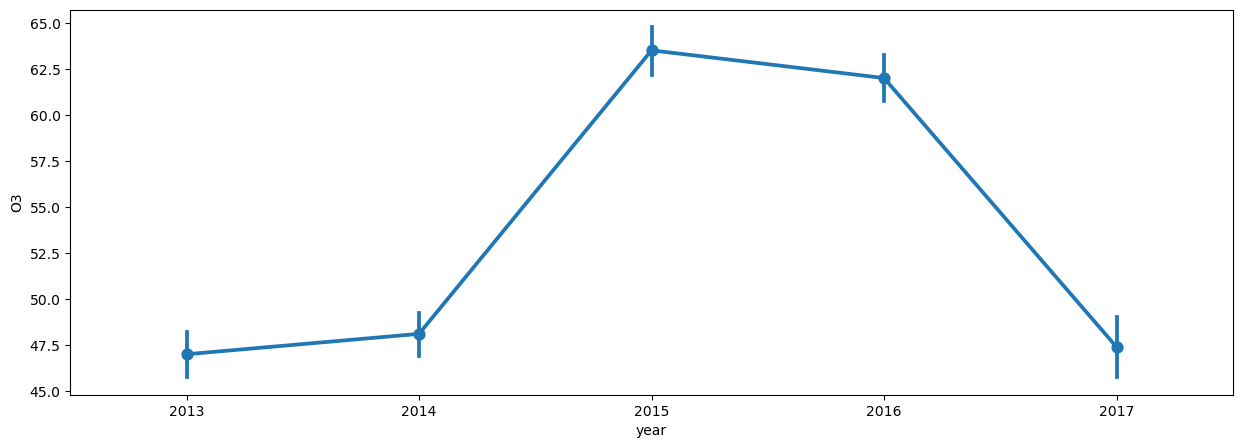

In [215]:
for pollutant in pollutants:    
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='year', y=pollutant, data=df)

### Monthly Analysis

In [216]:
df.month.value_counts()

month
3     2976
5     2976
7     2976
8     2976
10    2976
12    2976
1     2976
4     2880
6     2880
9     2880
11    2880
2     2712
Name: count, dtype: int64

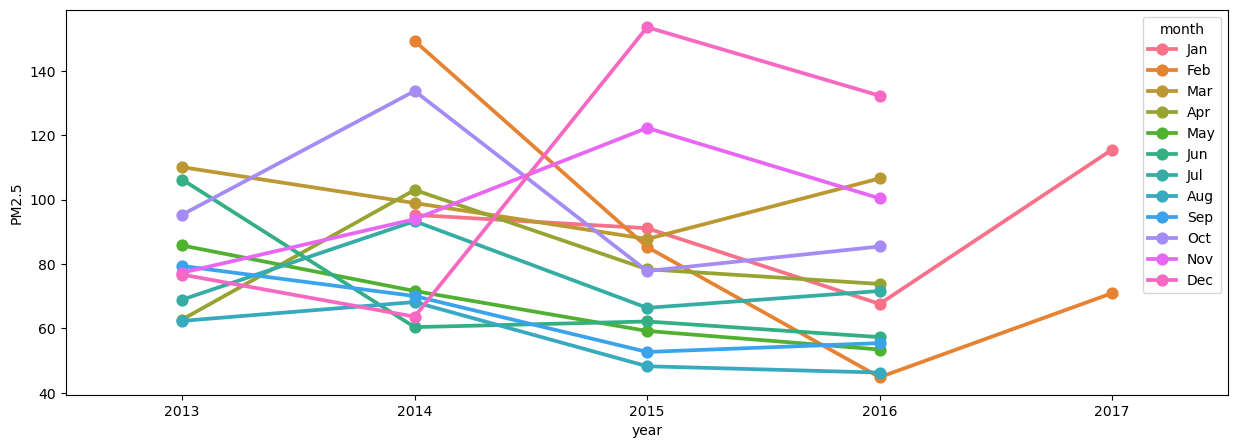

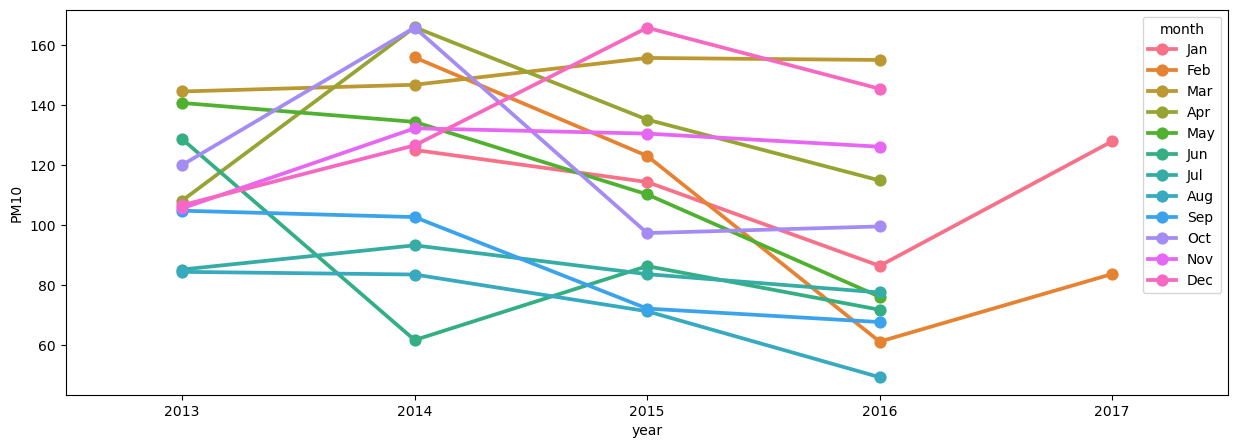

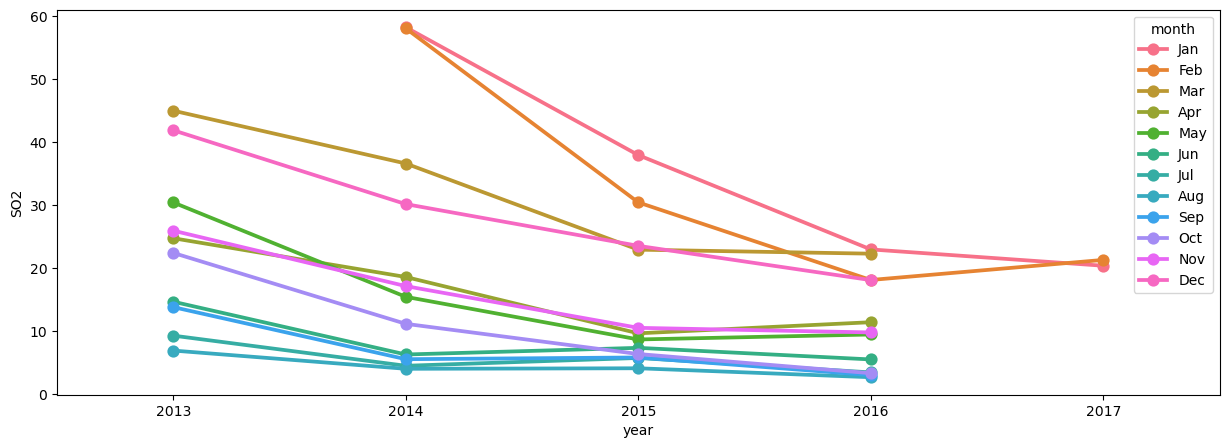

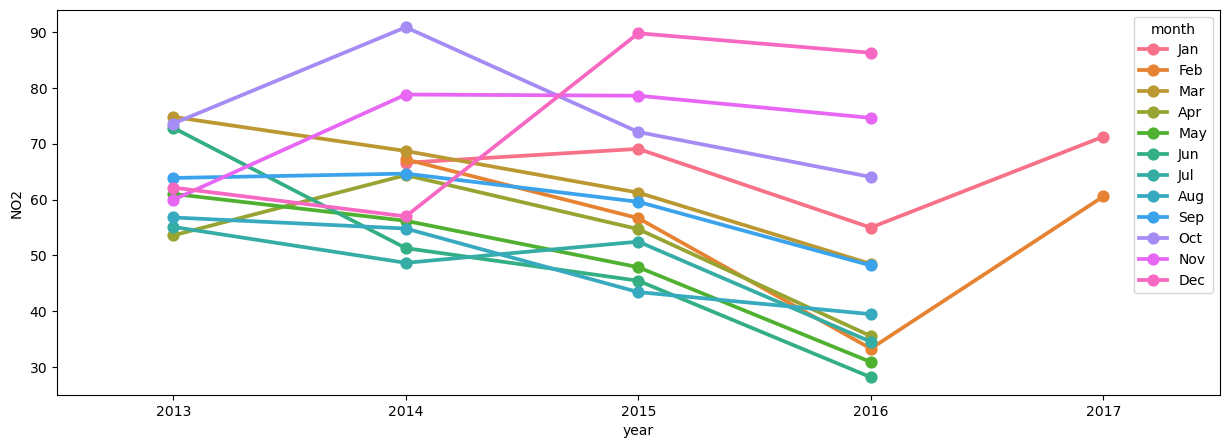

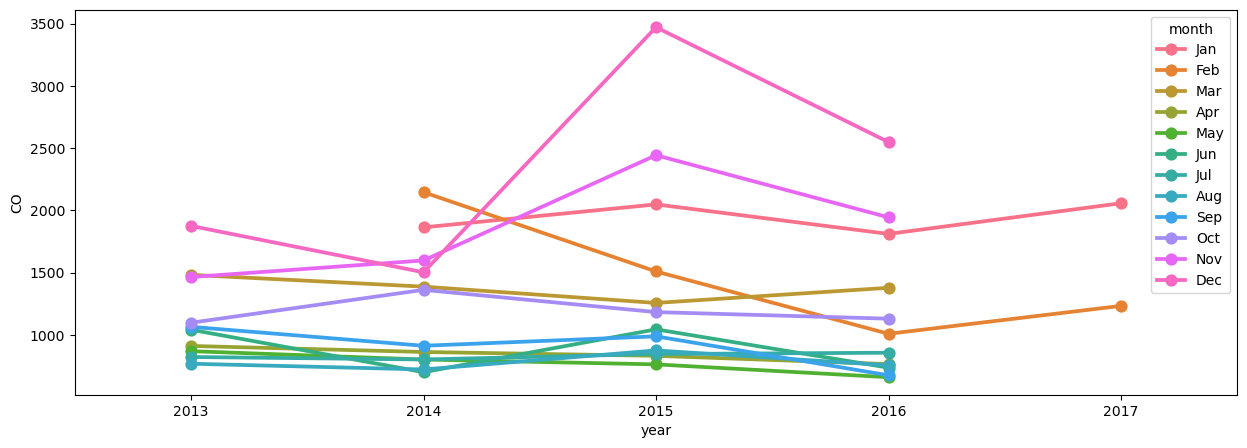

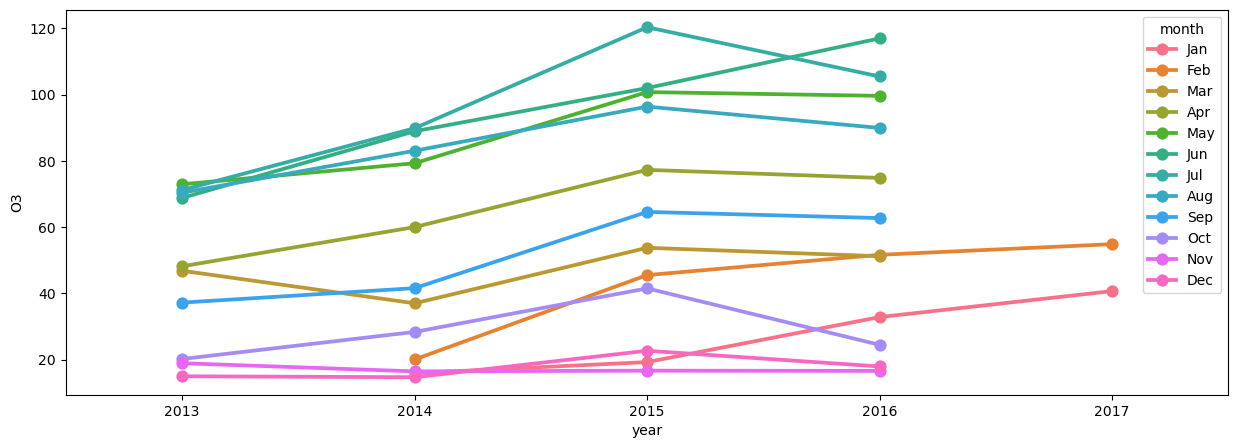

In [217]:
for pollutant in pollutants:
    temp_data = df.copy()
    temp_data.month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                           'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
    group_mounth = temp_data[[pollutant, 'month', 'year',]].groupby(["year",
                                                    "month"]).mean().reset_index().sort_values(by=['year',
                                                                                                   'month'], ascending=False)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='year', y=pollutant, data=group_mounth, hue='month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                                  'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

### Daily Analysis

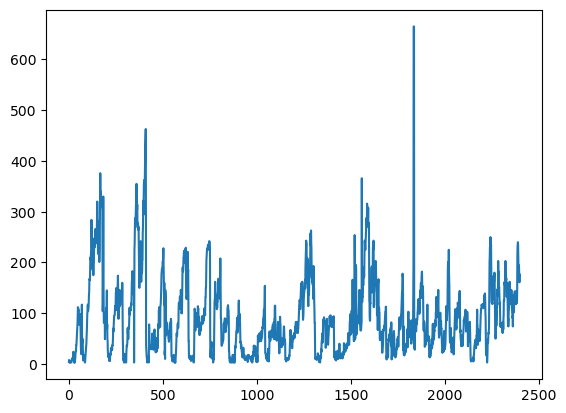

In [218]:
plt.plot(df.loc[:(24*100), 'PM2.5'])

## Feature Engineering

In [219]:
df.sample(10)

,DateTime,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
501,2013-03-21 21:00:00,2013,3,21,21,205.0,218.0,22.0,122.0,1700.0,6.000,4.8,1004.4,0.0,0.0,ENE,1.4
30011,2016-08-02 11:00:00,2016,8,2,11,35.0,35.0,2.0,15.0,500.0,116.000,31.4,1006.5,20.7,0.0,ESE,3.2
22935,2015-10-12 15:00:00,2015,10,12,15,8.0,8.0,2.0,14.0,400.0,99.000,25.1,1014.8,-1.7,0.0,W,3.2
6075,2013-11-09 03:00:00,2013,11,9,3,156.0,177.0,78.0,104.0,2800.0,2.142,5.0,1016.1,2.0,0.0,E,0.5
9866,2014-04-16 02:00:00,2014,4,16,2,47.0,131.0,9.0,75.0,400.0,6.000,13.5,1010.9,4.1,0.0,NE,0.9
23688,2015-11-13 00:00:00,2015,11,13,0,245.0,245.0,11.0,80.0,3900.0,5.000,6.5,1022.7,4.3,0.0,SSE,1.0
9860,2014-04-15 20:00:00,2014,4,15,20,51.0,162.0,10.0,73.0,800.0,16.000,15.5,1013.7,1.2,0.0,SW,1.5
127,2013-03-06 07:00:00,2013,3,6,7,188.0,196.0,92.0,129.0,2700.0,22.000,5.7,1009.3,-5.0,0.0,NE,1.7
18137,2015-03-26 17:00:00,2015,3,26,17,62.0,146.0,15.0,28.0,600.0,157.000,19.6,1021.2,-6.2,0.0,WSW,4.1
33669,2017-01-01 21:00:00,2017,1,1,21,459.0,491.0,8.0,168.0,7400.0,3.000,-3.4,1020.5,-5.1,0.0,ENE,0.8


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  35064 non-null  datetime64[ns]
 1   year      35064 non-null  int64         
 2   month     35064 non-null  int64         
 3   day       35064 non-null  int64         
 4   hour      35064 non-null  int64         
 5   PM2.5     35064 non-null  float64       
 6   PM10      35064 non-null  float64       
 7   SO2       35064 non-null  float64       
 8   NO2       35064 non-null  float64       
 9   CO        35064 non-null  float64       
 10  O3        35064 non-null  float64       
 11  TEMP      35064 non-null  float64       
 12  PRES      35064 non-null  float64       
 13  DEWP      35064 non-null  float64       
 14  RAIN      35064 non-null  float64       
 15  wd        35064 non-null  object        
 16  WSPM      35064 non-null  float64       
dtypes: datetime6

In [221]:
df.sample(10)

,DateTime,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
19591,2015-05-26 07:00:00,2015,5,26,7,105.0,214.0,15.0,66.0,900.0,64.0,24.0,1003.1,14.1,0.0,SSE,0.9
10425,2014-05-09 09:00:00,2014,5,9,9,78.0,164.0,68.0,84.0,2400.0,38.0,16.9,1010.2,7.3,0.0,ESE,2.3
23688,2015-11-13 00:00:00,2015,11,13,0,245.0,245.0,11.0,80.0,3900.0,5.0,6.5,1022.7,4.3,0.0,SSE,1.0
22094,2015-09-07 14:00:00,2015,9,7,14,21.0,32.0,2.0,25.0,600.0,144.0,28.5,1008.4,14.0,0.0,WNW,1.8
15627,2014-12-12 03:00:00,2014,12,12,3,9.0,36.0,8.0,10.0,300.0,46.0,-1.6,1028.0,-19.6,0.0,N,4.0
34406,2017-02-01 14:00:00,2017,2,1,14,8.0,8.0,7.0,11.0,400.0,88.0,4.5,1032.9,-24.6,0.0,WSW,1.5
29361,2016-07-06 09:00:00,2016,7,6,9,85.0,111.0,7.0,68.0,1200.0,42.0,28.6,1008.8,17.8,0.0,SSW,1.1
7680,2014-01-15 00:00:00,2014,1,15,0,103.0,122.0,73.0,95.0,2200.0,1.0,-8.4,1027.4,-12.4,0.0,SE,0.5
2916,2013-06-30 12:00:00,2013,6,30,12,246.0,222.0,18.0,61.0,2000.0,74.0,27.2,998.0,23.7,0.0,S,1.7
14218,2014-10-14 10:00:00,2014,10,14,10,27.0,63.0,5.0,53.0,500.0,8.0,16.7,1014.9,3.4,0.0,SW,1.0


#### Encoding Categorical Columns

In [222]:
label_encod = LabelEncoder()
df['wd'] = label_encod.fit_transform(df.wd)

In [223]:
df['wd'].value_counts()

wd
4     5221
1     3950
12    3359
0     2608
5     2445
15    2212
11    2098
3     2066
7     1860
2     1717
6     1589
9     1341
8     1304
13    1171
14    1101
10    1022
Name: count, dtype: int64

In [224]:
df.sample(10)

,DateTime,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
8130,2014-02-02 18:00:00,2014,2,2,18,3.0,39.0,7.0,12.0,300.0,63.0000,4.0,1013.4,-22.9,0.0,4,3.9
10189,2014-04-29 13:00:00,2014,4,29,13,111.0,143.0,27.0,67.0,1000.0,130.0000,26.2,1005.9,6.2,0.0,12,3.2
15221,2014-11-25 05:00:00,2014,11,25,5,136.0,195.0,12.0,91.0,3500.0,2.0000,0.4,1028.0,-3.0,0.0,1,1.0
1486,2013-05-01 22:00:00,2013,5,1,22,56.0,126.0,28.0,49.0,700.0,53.0000,17.6,1007.1,4.9,0.0,8,1.5
6183,2013-11-13 15:00:00,2013,11,13,15,179.0,207.0,83.0,120.0,3500.0,21.2058,9.2,1012.6,2.5,0.0,14,0.6
32627,2016-11-19 11:00:00,2016,11,19,11,34.0,34.0,10.0,22.0,600.0,48.0000,12.7,1014.8,-2.8,0.0,5,1.9
6933,2013-12-14 21:00:00,2013,12,14,21,38.0,32.0,26.0,59.0,1700.0,6.4260,-4.3,1025.2,-12.7,0.0,15,0.5
29365,2016-07-06 13:00:00,2016,7,6,13,90.0,90.0,4.0,16.0,700.0,251.0000,33.4,1007.2,15.9,0.0,11,1.9
26854,2016-03-23 22:00:00,2016,3,23,22,9.0,30.0,2.0,26.0,400.0,67.0000,8.1,1029.3,-14.9,0.0,1,2.3
32454,2016-11-12 06:00:00,2016,11,12,6,54.0,85.0,4.0,56.0,1000.0,2.0000,1.7,1015.1,-1.6,0.0,11,0.5


#### Correlation Analysis of the Columns

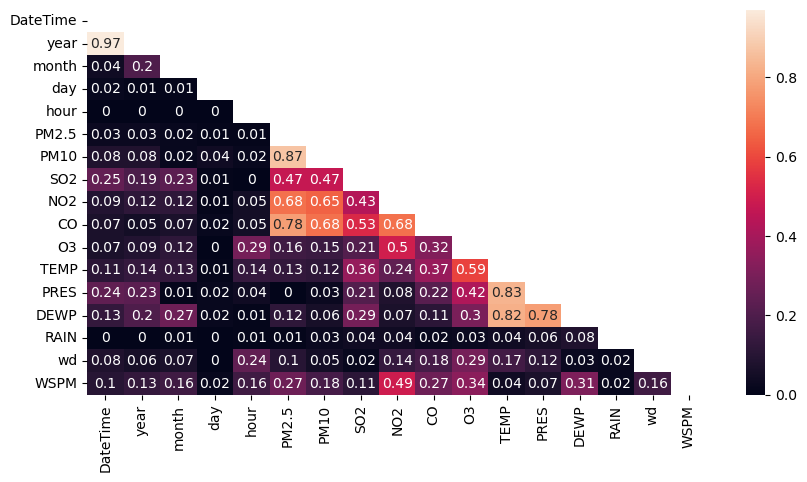

In [225]:
# Correlations of the columns
plt.figure(figsize= (10, 5))

# Calculate correlation matrix
corr_matrix = np.round(df.corr().abs(),2)

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap with masked upper triangle
sns.heatmap(corr_matrix, annot=True, mask=mask)
#plt.savefig("confusion_matrix.pdf")
plt.show()

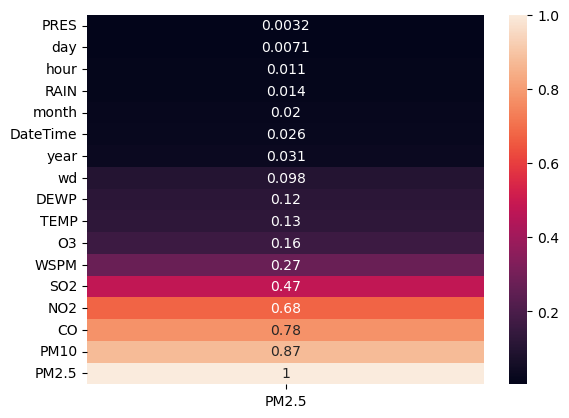

In [226]:
# Correlations of the features and the target (PM2.5)
sns.heatmap(df.corr()[['PM2.5']].abs().sort_values(by = 'PM2.5'), annot = True)
plt.show()

### Additional Exploratory Data Analysis

In [227]:
df.columns

Index(['DateTime', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2',
       'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'],
      dtype='object')

In [228]:
# Defining air pollutants list
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

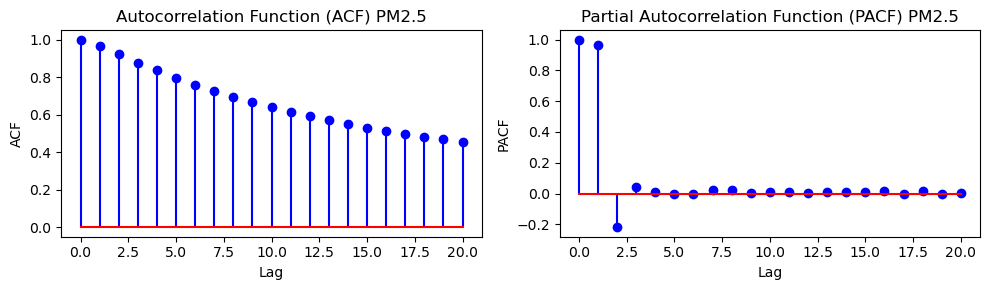

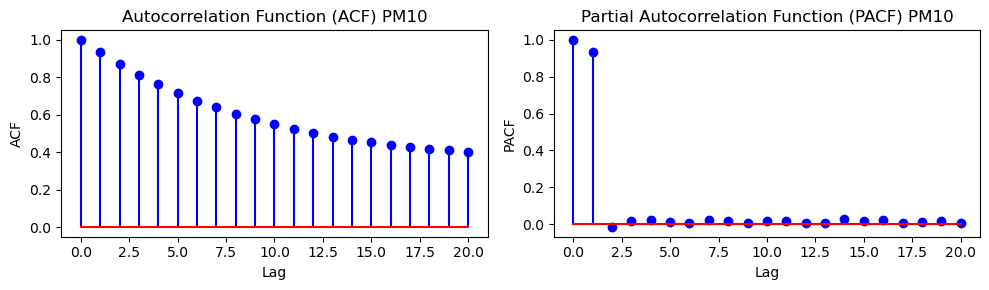

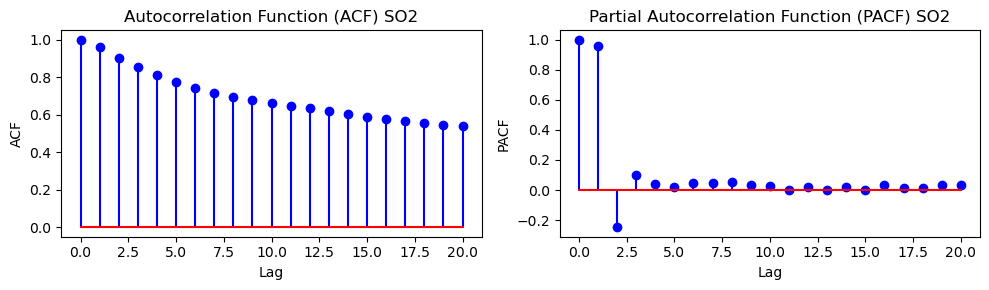

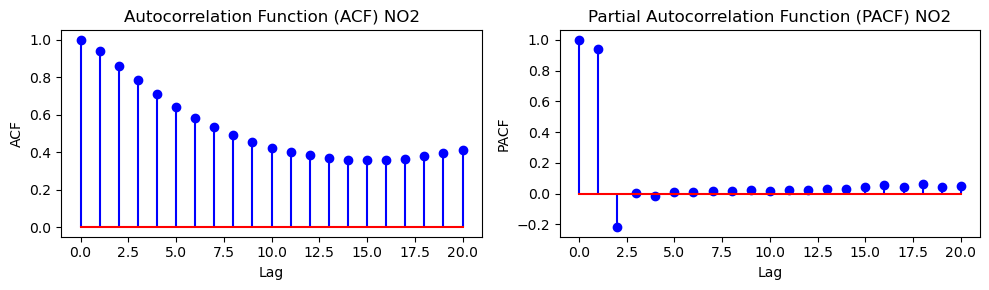

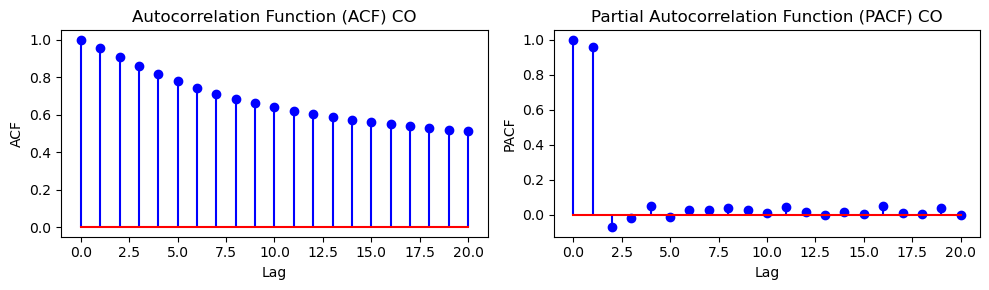

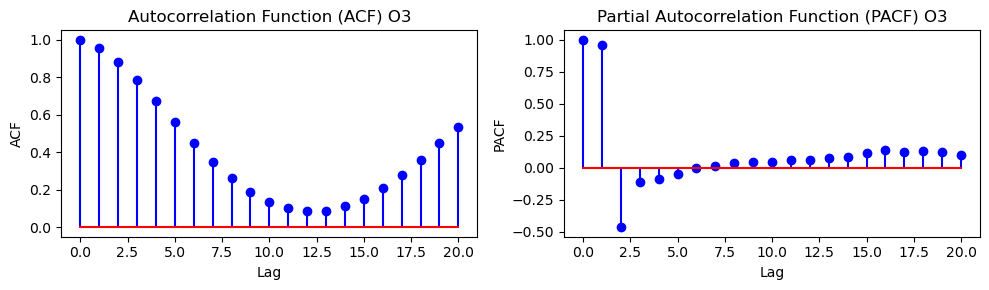

In [229]:
# ACF and PACF Plots of the air pollutants
for pollutant in pollutants:
    # Compute the ACF and PACF using statsmodels
    acf_values, confint = sm.tsa.acf(df[pollutant], nlags=20, alpha=0.05)
    pacf_values, confint = sm.tsa.pacf(df[pollutant], nlags=20, alpha=0.05)

    # Plot ACF and PACF
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.stem(acf_values, linefmt='b-', markerfmt='bo', basefmt='r-')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title('Autocorrelation Function (ACF) ' + pollutant)

    plt.subplot(1, 2, 2)
    plt.stem(pacf_values, linefmt='b-', markerfmt='bo', basefmt='r-')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.title('Partial Autocorrelation Function (PACF) ' + pollutant)
    
    plt.tight_layout()
    plt.show()


### Removing some columns

In [230]:
df.sample(5)

,DateTime,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
28579,2016-06-03 19:00:00,2016,6,3,19,98.0,174.0,30.0,30.0,1300.0,244.0,27.5,1000.6,11.1,0.0,11,1.4
8846,2014-03-04 14:00:00,2014,3,4,14,7.0,22.0,7.0,9.0,400.0,78.0,9.3,1019.5,-19.8,0.0,14,3.9
33555,2016-12-28 03:00:00,2016,12,28,3,155.0,155.0,7.0,69.0,1600.0,3.0,-2.1,1026.9,-5.3,0.0,15,2.9
5756,2013-10-26 20:00:00,2013,10,26,20,108.0,163.0,23.0,123.0,1300.0,1.0,6.1,1014.3,3.4,0.0,10,0.0
27666,2016-04-26 18:00:00,2016,4,26,18,65.0,87.0,13.0,32.0,700.0,148.0,21.2,1009.7,3.8,0.0,9,2.1


In [231]:
df.drop( columns = ['DateTime', 'year', 'month', 'day', 'hour'], inplace = True)

In [232]:
df.sample(5)

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
30050,79.0,79.0,2.0,24.0,1000.0,127.0,29.0,1005.6,24.1,0.0,8,0.9
7811,9.0,20.0,8.0,4.0,500.0,53.0,1.5,1024.1,-17.4,0.0,7,5.5
21327,91.0,141.0,3.0,39.0,1100.0,200.0,30.1,1002.5,20.9,0.0,2,2.1
14721,56.0,92.0,11.0,58.0,900.0,6.0,7.9,1020.0,0.8,0.0,4,2.0
30918,21.0,50.0,2.0,68.0,400.0,2.0,18.1,1004.2,14.0,0.0,4,1.1


### Outliers Detection and Data Normalization

In [233]:
numerical_cols = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM']

SKEW VALUE OF  PM2.5 IS : 1.9800641058302373
SKEW VALUE OF  PM10 IS : 1.8001549662418992
SKEW VALUE OF  SO2 IS : 2.7739673628209958
SKEW VALUE OF  NO2 IS : 0.9279824002606979
SKEW VALUE OF  CO IS : 2.715039184815808
SKEW VALUE OF  O3 IS : 1.4600788194753591
SKEW VALUE OF  TEMP IS : -0.09382290952618104
SKEW VALUE OF  PRES IS : 0.11107157266244896
SKEW VALUE OF  DEWP IS : -0.21278123891998096
SKEW VALUE OF  RAIN IS : 34.72920422226938
SKEW VALUE OF  WSPM IS : 1.3654129381021667


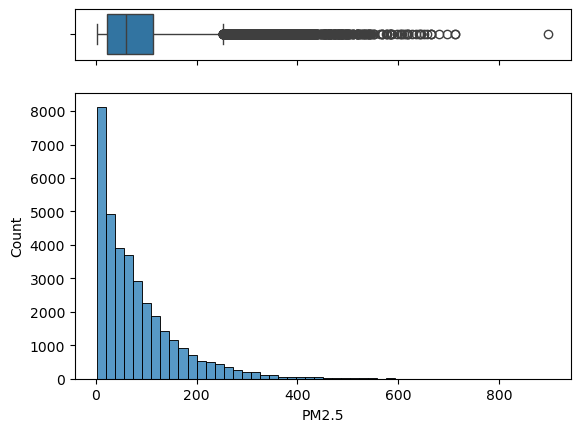

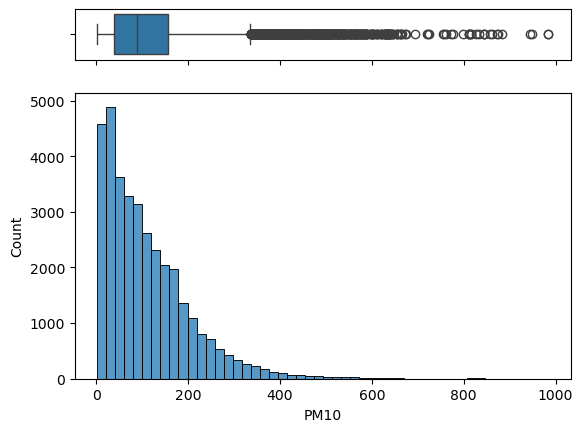

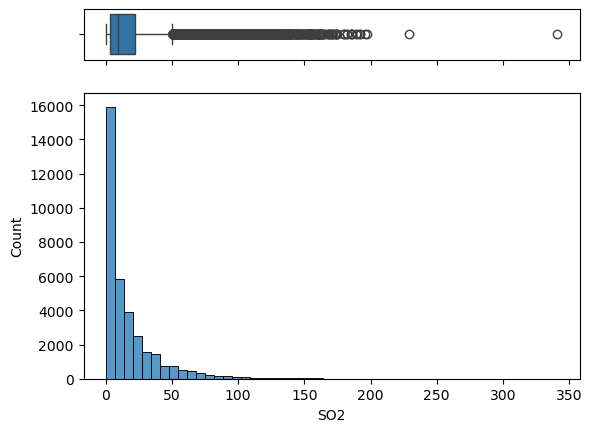

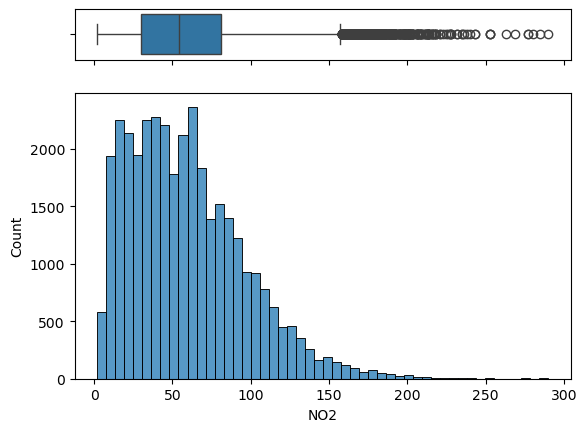

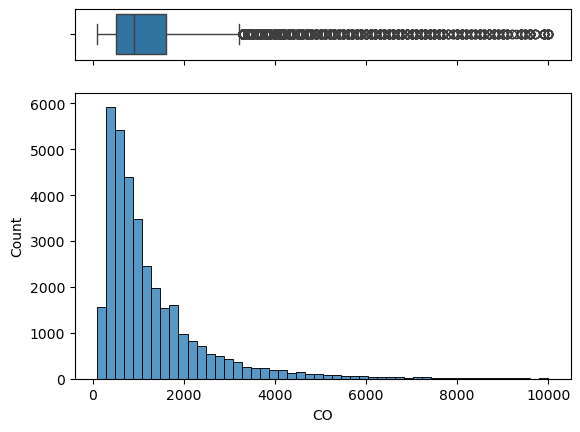

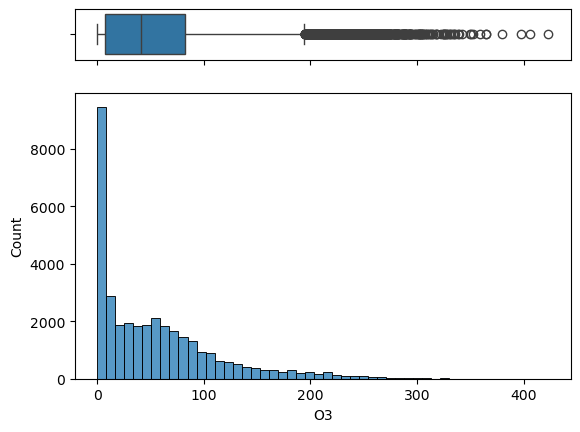

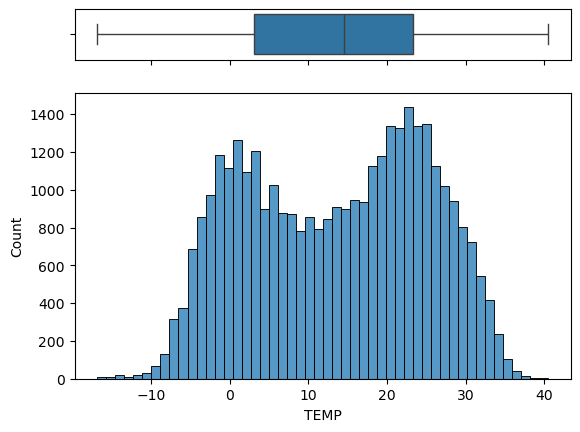

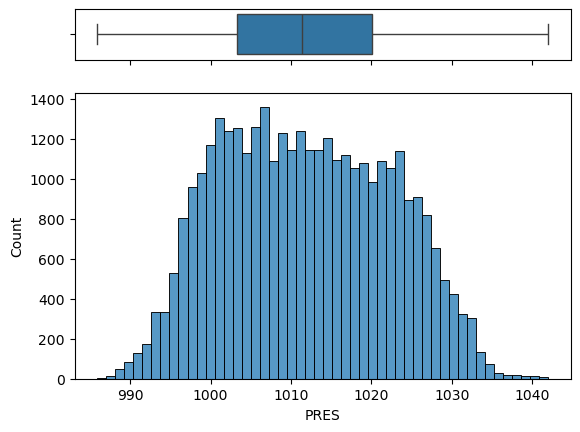

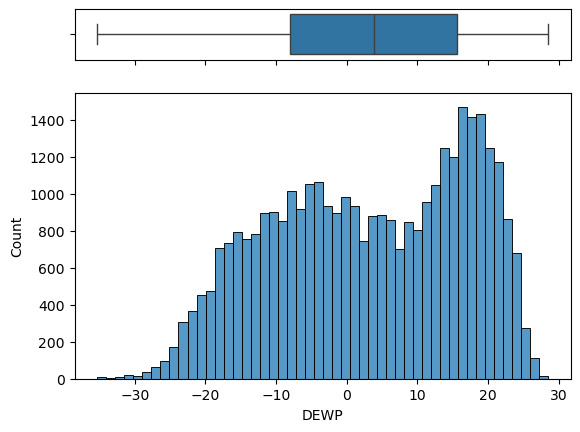

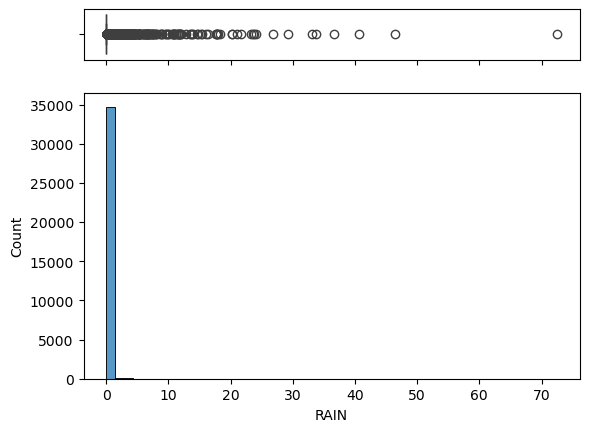

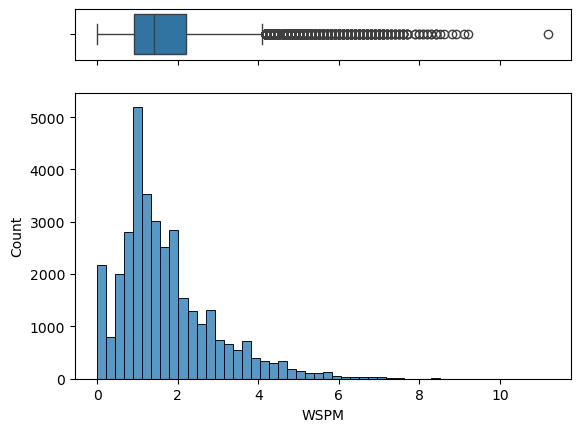

In [234]:
for col in numerical_cols:

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Add a graph in each part
    sns.boxplot(x = df[col], ax=ax_box)
    sns.histplot(x = df[col], ax=ax_hist, bins = 50)
    
    print("SKEW VALUE OF ", col, "IS :", df[col].skew())

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')

# Show the plot
plt.show()

In [235]:
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
PM2.5,35064.0,83.163652,82.290700,3.0000,22.0,60.0,114.0,898.0
PM10,35064.0,110.733262,95.375762,2.0000,38.0,88.0,157.0,984.0
SO2,35064.0,17.573220,22.819302,0.2856,3.0,9.0,22.0,341.0
NO2,35064.0,59.290826,37.007696,2.0000,30.0,54.0,81.0,290.0
CO,35064.0,1267.071954,1242.121599,100.0000,500.0,900.0,1600.0,10000.0
O3,35064.0,55.184512,57.582259,0.2142,7.0,41.0,82.0,423.0
TEMP,35064.0,13.581908,11.400761,-16.8000,3.1,14.5,23.3,40.5
PRES,35064.0,1011.851716,10.404909,985.9000,1003.3,1011.4,1020.1,1042.0
DEWP,35064.0,3.120283,13.690615,-35.3000,-8.1,3.8,15.6,28.5
RAIN,35064.0,0.067383,0.909798,0.0000,0.0,0.0,0.0,72.5


SKEW VALUE OF  PM2.5 IS : -0.3077869126948916
SKEW VALUE OF  PM10 IS : -0.4899728149584272
SKEW VALUE OF  SO2 IS : 0.4051803752041444
SKEW VALUE OF  NO2 IS : -0.7029767909124982
SKEW VALUE OF  CO IS : 0.18989527393986866
SKEW VALUE OF  O3 IS : -0.4677803241148721
SKEW VALUE OF  RAIN IS : 10.592203711561375
SKEW VALUE OF  WSPM IS : 0.10329341640557892


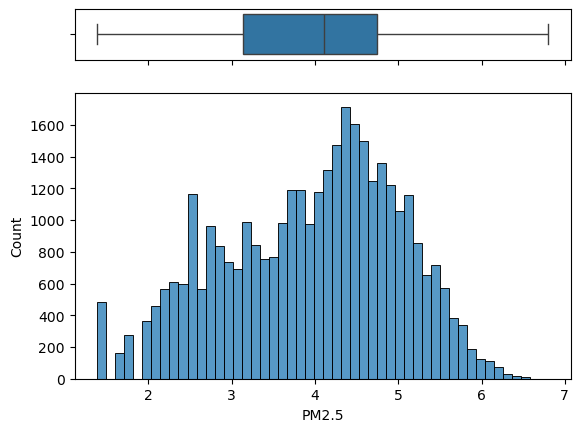

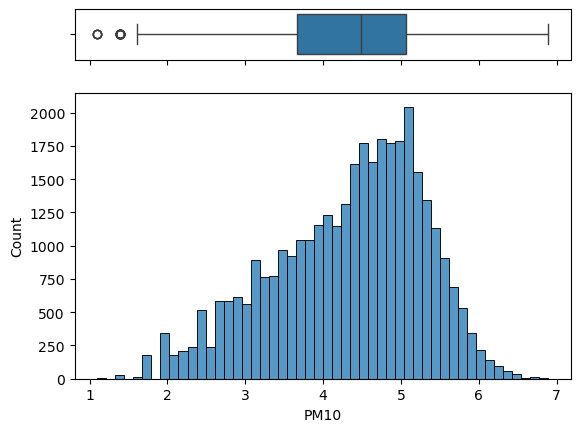

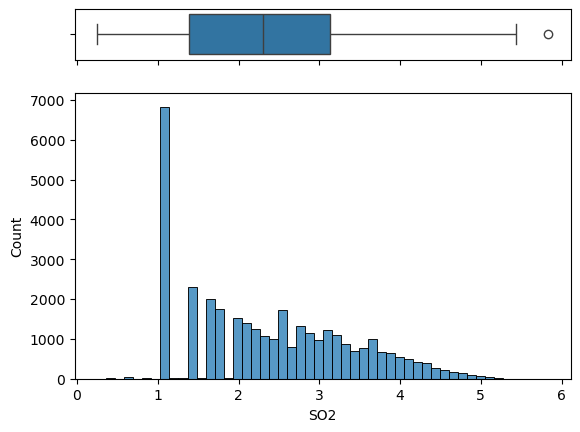

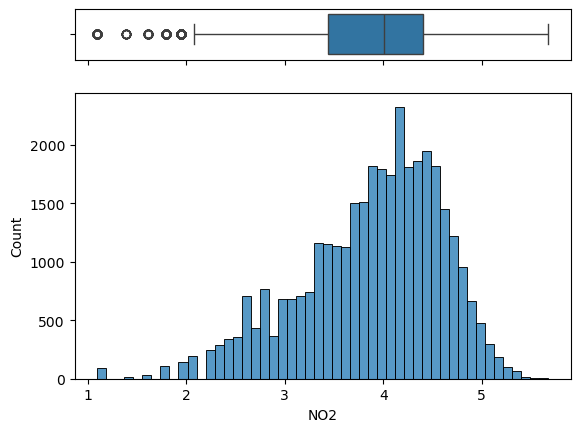

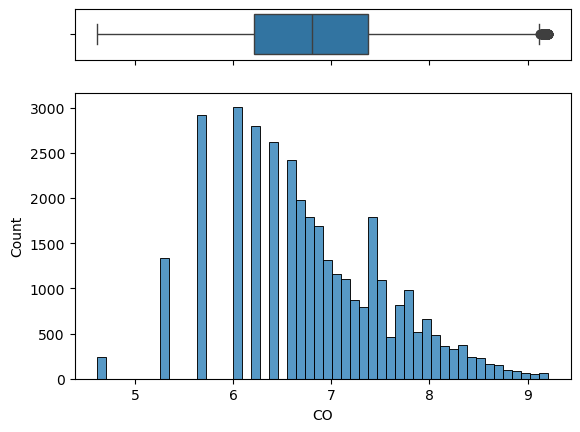

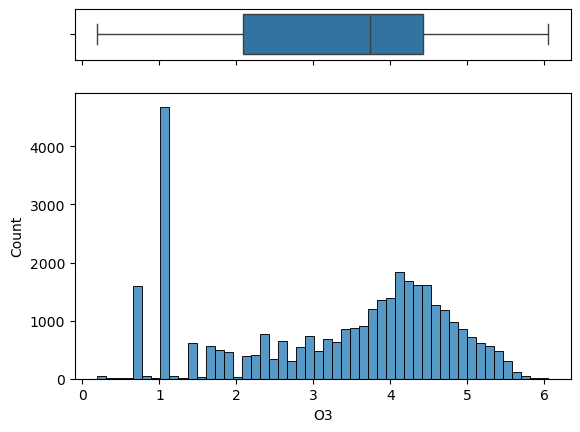

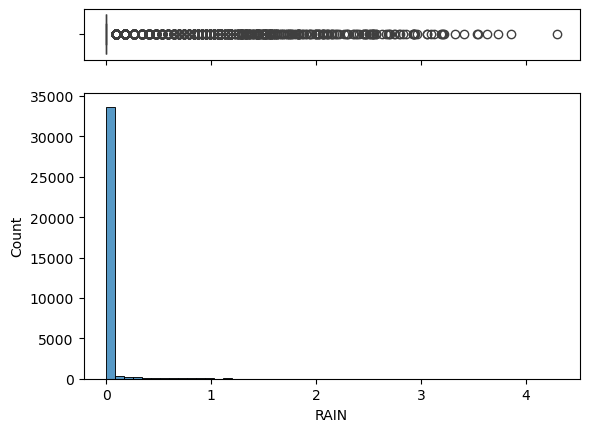

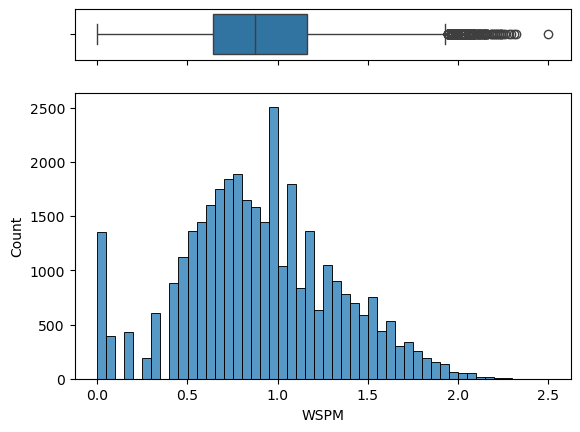

In [236]:
for col in numerical_cols:
    
    if col in ['TEMP', 'PRES', 'DEWP']:
        continue

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Add a graph in each part
    sns.boxplot(x = np.log(df[col] + 1), ax=ax_box)
    sns.histplot(x = np.log(df[col] + 1), ax=ax_hist, bins = 50)
    
    print("SKEW VALUE OF ", col, "IS :", np.log(df[col] + 1).skew())

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')

# Show the plot
plt.show()

In [237]:
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,3,2.0


In [238]:
SEQ_LENGTH = 1

In [239]:
# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # Predicting PM2.5 value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [240]:
df.isna().sum()

PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64

In [241]:
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,6,1.2


## Building A Pre-trained Model for PM2.5 Forecasting

Let's build a pre-trained model to forecast the hourly concentrations of PM2.5. Then, we use the extracted knowledge to forecast the concentrations of other pollutants.

In [242]:
def evaluate_model(y_true, y_pred):
    print("Mean absolute error: ", mean_absolute_error(y_true, y_pred))
    print("Mean squared error: ", mean_squared_error(y_true, y_pred))
    print("Root Mean squared error: ", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("Mean absolute percentage error: ", mean_absolute_percentage_error(y_true, y_pred))
    print("RSquared: ", r2_score(y_true, y_pred))

In [243]:
# Defining features and target
features_pm25 = df.drop(columns = ['PM10','SO2','NO2','CO','O3'])

In [244]:
features_pm25

,PM2.5,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...
35059,12.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,13.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,16.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,21.0,10.5,1014.4,-12.9,0.0,6,1.2


In [245]:
# Changing the position of the 'wd' column

# Column to move
col_to_move = 'wd'

# Get a list of all columns
cols = list(features_pm25.columns)

# Remove the column from the list
cols.remove(col_to_move)

# Append the column to the end of the list
cols.append(col_to_move)

# Reindex the DataFrame
features_pm25 = features_pm25[cols]

In [246]:
features_pm25

,PM2.5,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,4.0,-0.7,1023.0,-18.8,0.0,4.4,6
1,8.0,-1.1,1023.2,-18.2,0.0,4.7,3
2,7.0,-1.1,1023.5,-18.2,0.0,5.6,6
3,6.0,-1.4,1024.5,-19.4,0.0,3.1,7
4,3.0,-2.0,1025.2,-19.5,0.0,2.0,3
...,...,...,...,...,...,...,...
35059,12.0,12.5,1013.5,-16.2,0.0,2.4,7
35060,13.0,11.6,1013.6,-15.1,0.0,0.9,14
35061,16.0,10.8,1014.2,-13.3,0.0,1.1,7
35062,21.0,10.5,1014.4,-12.9,0.0,1.2,6


### Train, Validation, Test Split

In [285]:
# Defining the sizes of train (60%), validation (20%), and test (20%)
train_size = 0.6
val_test_size = 0.2

len_train = int(train_size * len(features_pm25))
len_val_test = int(val_test_size * len(features_pm25))

train_df = features_pm25.iloc[:len_train, :-1]
val_df = features_pm25.iloc[len_train:len_train+len_val_test, :-1]
test_df = features_pm25.iloc[len_train + len_val_test:, :-1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [248]:
train_df

,PM2.5,TEMP,PRES,DEWP,RAIN,WSPM
0,-1.052462,-1.371326,1.283933,-1.689462,-0.070494,2.286821
1,-1.000239,-1.407732,1.303833,-1.644984,-0.070494,2.534670
2,-1.013295,-1.407732,1.333684,-1.644984,-0.070494,3.278218
3,-1.026350,-1.435037,1.433186,-1.733940,-0.070494,1.212809
4,-1.065517,-1.489646,1.502837,-1.741353,-0.070494,0.304029
...,...,...,...,...,...,...
21033,-0.125511,1.140689,-1.243418,1.209038,-0.070494,-0.522135
21034,0.096435,1.186196,-1.263319,1.238690,-0.070494,-0.522135
21035,0.344492,1.368227,-1.313070,1.268342,-0.070494,-0.356902
21036,0.553383,1.486546,-1.323020,1.231277,-0.070494,-0.109053


In [249]:
train_df['wd'] = features_pm25.iloc[:len_train, -1]
val_df['wd'] = features_pm25.iloc[len_train:len_train+len_val_test, -1]
test_df['wd'] = features_pm25.iloc[len_train + len_val_test:, -1]

In [250]:
train_df

,PM2.5,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,-1.052462,-1.371326,1.283933,-1.689462,-0.070494,2.286821,6
1,-1.000239,-1.407732,1.303833,-1.644984,-0.070494,2.534670,3
2,-1.013295,-1.407732,1.333684,-1.644984,-0.070494,3.278218,6
3,-1.026350,-1.435037,1.433186,-1.733940,-0.070494,1.212809,7
4,-1.065517,-1.489646,1.502837,-1.741353,-0.070494,0.304029,3
...,...,...,...,...,...,...,...
21033,-0.125511,1.140689,-1.243418,1.209038,-0.070494,-0.522135,2
21034,0.096435,1.186196,-1.263319,1.238690,-0.070494,-0.522135,15
21035,0.344492,1.368227,-1.313070,1.268342,-0.070494,-0.356902,0
21036,0.553383,1.486546,-1.323020,1.231277,-0.070494,-0.109053,15


In [251]:
train_df.describe()

,PM2.5,TEMP,PRES,DEWP,RAIN,WSPM,wd
count,2.103800e+04,2.103800e+04,2.103800e+04,21038.000000,2.103800e+04,21038.000000,21038.000000
mean,-5.944269e-17,1.188854e-16,-1.048353e-15,0.000000,2.364198e-17,0.000000,6.822607
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,4.755864
min,-1.065517e+00,-2.417999e+00,-2.407592e+00,-2.660570,-7.049354e-02,-1.348298,0.000000
25%,-7.521818e-01,-8.889466e-01,-8.155595e-01,-0.829549,-7.049354e-02,-0.687367,3.000000
50%,-2.430116e-01,1.213204e-01,-5.934420e-02,0.067429,-7.049354e-02,-0.191669,5.000000
75%,4.228264e-01,8.130348e-01,7.864229e-01,0.912516,-7.049354e-02,0.469262,12.000000
max,7.577320e+00,2.378494e+00,2.577459e+00,1.816907,8.024070e+01,7.904733,15.000000


In [252]:
# Creating sequences
X_train_pm25, y_train_pm25 = create_sequences(np.array(train_df), SEQ_LENGTH)
X_val_pm25, y_val_pm25 = create_sequences(np.array(val_df), SEQ_LENGTH)
X_test_pm25, y_test_pm25 = create_sequences(np.array(test_df), SEQ_LENGTH)

In [253]:
X_train_pm25[0]

array([[-1.05246162, -1.3713264 ,  1.28393293, -1.68946177, -0.07049354,
         2.28682127,  6.        ]])

In [254]:
y_train_pm25[0]

-1.000239032215473

In [255]:
print("Train shape: ", X_train_pm25.shape)
print("Test shape: ", X_test_pm25.shape)
print("Validation shape: ", X_val_pm25.shape)

Train shape:  (21037, 1, 7)
Test shape:  (7013, 1, 7)
Validation shape:  (7011, 1, 7)


In [256]:
## ADD OPTUNA CODE HERE

In [257]:
# These hyperparameters were obtained using OPTUNA
best_params_ann = {'num_hidden_layers': 1, 'num_units': 8, 'dropout_rate': 0.14382634727054072, 
                  'learning_rate': 0.001540087615233534, 'regularization': None, 
                  'regularization_strength': 0}

In [258]:
# ANN/MLP Model
def build_ann_model(input_shape):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(8, activation='relu'))
              
    model.add(Dropout(best_params_ann['dropout_rate']))
        
    model.add(Dense(1, activation='linear'))
                  
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [259]:
# Simple RNN Model
def build_rnn_model(input_shape):
    
    model = Sequential()
    
    model.add(SimpleRNN(8, activation='relu', input_shape=input_shape, return_sequences=False))
                  
    model.add(Dropout(best_params_ann['dropout_rate']))
        
    model.add(Dense(1, activation='linear'))
                  
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [260]:
# GRU Model
def build_gru_model(input_shape):
    
    model = Sequential()
    
    model.add(GRU(8, activation='relu', input_shape=input_shape, return_sequences=False))
    
    model.add(Dropout(best_params_ann['dropout_rate']))
        
    model.add(Dense(1, activation='linear'))
                  
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [261]:
# LSTM Model
def build_lstm_model(input_shape):
    
    model = Sequential()
    
    model.add(LSTM(8, activation='relu', input_shape=input_shape, return_sequences=False))
        
    model.add(Dropout(best_params_ann['dropout_rate']))
        
    model.add(Dense(1, activation='linear'))
                  
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [262]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r_squared = r2_score(y_true, y_pred)
    
    return mae, mse, rmse, mape, r_squared

In [263]:
def plot_predictions(results, y_test):
    plt.figure(figsize=(14, 8))
    
    for name, result in results.items():
        plt.plot(result['predictions'][:500], label=f"{name} Predictions")
    
    plt.plot(y_test[:500], label="True Values", linestyle='dashed', color='black')
    plt.title("Model Predictions vs True Values")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [264]:
def train_and_evaluate(models, epochs, batch_size):
    results = {}
    
    for name, build_model in models.items():
        print(f"Training {name} model...")
        
        # Build the model
        model = build_model(X_train_pm25.shape[1:])
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        
        # Train the model
        history = model.fit(X_train_pm25, y_train_pm25, epochs=epochs, 
                            batch_size=batch_size, validation_data = (X_val_pm25, y_val_pm25),
                           shuffle=False, callbacks=[early_stopping])
        
        # Evaluate the model
        evaluation_train = model.evaluate(X_train_pm25, y_train_pm25, verbose=0)
        evaluation_val = model.evaluate(X_val_pm25, y_val_pm25, verbose=0)
        evaluation = model.evaluate(X_test_pm25, y_test_pm25, verbose=0)
        
        # Make predictions
        predictions = model.predict(X_test_pm25)
        predictions_train = model.predict(X_train_pm25)
        predictions_val = model.predict(X_val_pm25)
        
        # Calculate metrics
        mae, mse, rmse, mape, r_squared = calculate_metrics(y_test_pm25, predictions)
        mae_train, mse_train, rmse_train, mape_train, r_squared_train = calculate_metrics(y_train_pm25, predictions_train)
        mae_val, mse_val, rmse_val, mape_val, r_squared_val = calculate_metrics(y_val_pm25, predictions_val)
        
        # Save model weights
        #model.save(f"pre_trained_models/{name}_model.h5")
        
        results[name] = {
            'model': model,
            'history': history,
            'evaluation': evaluation,
            'predictions': predictions,
            'metrics': {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'R_squared': r_squared
            }
        }
        
        
        print(f"{name} model metrics train: MAE={mae_train}, MSE={mse_train}, RMSE={rmse_train}, MAPE={mape_train}, R_squared={r_squared_train}")
        print(f"{name} model metrics val: MAE={mae_val}, MSE={mse_val}, RMSE={rmse_val}, MAPE={mape_val}, R_squared={r_squared_val}")
        print(f"{name} model metrics test: MAE={mae}, MSE={mse}, RMSE={rmse}, MAPE={mape}, R_squared={r_squared}")
        
        # Plot training & validation loss values
        plt.plot(history.history['loss'], marker = ".")
        plt.plot(history.history['val_loss'], marker = ".")
        #plt.title(f'{name} Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        #plt.savefig(f"loss_plot_{name}.pdf")
        plt.show()
        
    return results

Training ANN model...
Epoch 1/100
658/658 [==============================] - 2s 2ms/step - loss: 0.5502 - mae: 0.5249 - val_loss: 0.1828 - val_mae: 0.3175
Epoch 2/100
658/658 [==============================] - 2s 3ms/step - loss: 0.2089 - mae: 0.3132 - val_loss: 0.1280 - val_mae: 0.2436
Epoch 3/100
658/658 [==============================] - 2s 3ms/step - loss: 0.1652 - mae: 0.2714 - val_loss: 0.1071 - val_mae: 0.2000
Epoch 4/100
658/658 [==============================] - 2s 3ms/step - loss: 0.1379 - mae: 0.2399 - val_loss: 0.0978 - val_mae: 0.1779
Epoch 5/100
658/658 [==============================] - 2s 3ms/step - loss: 0.1232 - mae: 0.2194 - val_loss: 0.0963 - val_mae: 0.1726
Epoch 6/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1181 - mae: 0.2133 - val_loss: 0.0942 - val_mae: 0.1663
Epoch 7/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1177 - mae: 0.2095 - val_loss: 0.0967 - val_mae: 0.1638
Epoch 8/100
658/658 [==========================

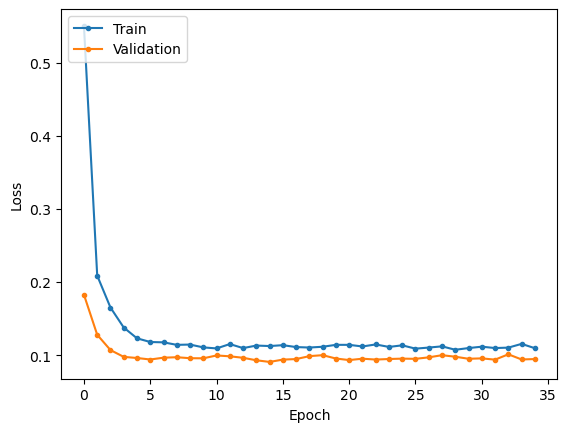

Training RNN model...
Epoch 1/100
658/658 [==============================] - 4s 4ms/step - loss: 1.1126 - mae: 0.6710 - val_loss: 0.2194 - val_mae: 0.2987
Epoch 2/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2364 - mae: 0.3055 - val_loss: 0.1171 - val_mae: 0.2001
Epoch 3/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1706 - mae: 0.2510 - val_loss: 0.1040 - val_mae: 0.1842
Epoch 4/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1708 - mae: 0.2394 - val_loss: 0.1013 - val_mae: 0.1783
Epoch 5/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1613 - mae: 0.2328 - val_loss: 0.1014 - val_mae: 0.1748
Epoch 6/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1432 - mae: 0.2302 - val_loss: 0.1027 - val_mae: 0.1752
Epoch 7/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1417 - mae: 0.2309 - val_loss: 0.1065 - val_mae: 0.1802
Epoch 8/100
658/658 [==========================

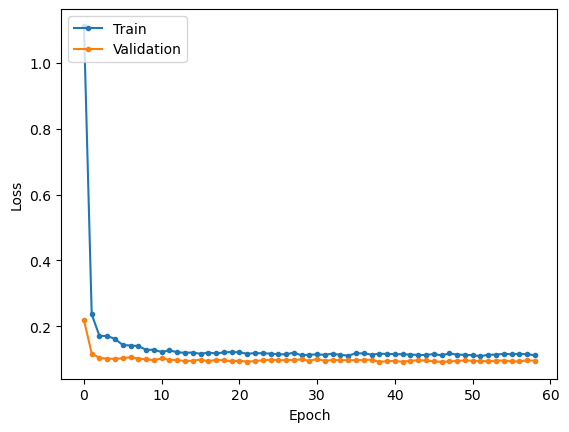

Training GRU model...
Epoch 1/100
658/658 [==============================] - 4s 3ms/step - loss: 0.3887 - mae: 0.4231 - val_loss: 0.1630 - val_mae: 0.2758
Epoch 2/100
658/658 [==============================] - 2s 3ms/step - loss: 0.1420 - mae: 0.2466 - val_loss: 0.1160 - val_mae: 0.2008
Epoch 3/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1244 - mae: 0.2248 - val_loss: 0.1060 - val_mae: 0.1840
Epoch 4/100
658/658 [==============================] - 3s 5ms/step - loss: 0.1179 - mae: 0.2130 - val_loss: 0.1089 - val_mae: 0.1834
Epoch 5/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1130 - mae: 0.2078 - val_loss: 0.1087 - val_mae: 0.1813
Epoch 6/100
658/658 [==============================] - 3s 5ms/step - loss: 0.1094 - mae: 0.2031 - val_loss: 0.1010 - val_mae: 0.1709
Epoch 7/100
658/658 [==============================] - 3s 5ms/step - loss: 0.1094 - mae: 0.2021 - val_loss: 0.1045 - val_mae: 0.1746
Epoch 8/100
658/658 [==========================

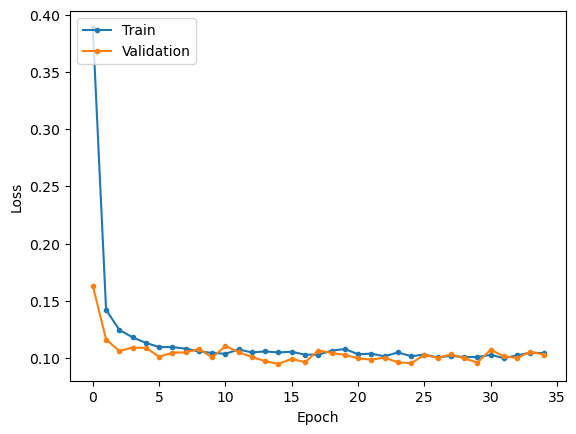

Training LSTM model...
Epoch 1/100
658/658 [==============================] - 4s 3ms/step - loss: 0.4381 - mae: 0.4894 - val_loss: 0.2183 - val_mae: 0.3423
Epoch 2/100
658/658 [==============================] - 3s 5ms/step - loss: 0.1755 - mae: 0.2920 - val_loss: 0.1365 - val_mae: 0.2386
Epoch 3/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1376 - mae: 0.2408 - val_loss: 0.1062 - val_mae: 0.1927
Epoch 4/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1259 - mae: 0.2209 - val_loss: 0.1036 - val_mae: 0.1876
Epoch 5/100
658/658 [==============================] - 2s 3ms/step - loss: 0.1226 - mae: 0.2155 - val_loss: 0.1014 - val_mae: 0.1827
Epoch 6/100
658/658 [==============================] - 2s 3ms/step - loss: 0.1171 - mae: 0.2116 - val_loss: 0.1005 - val_mae: 0.1754
Epoch 7/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1189 - mae: 0.2090 - val_loss: 0.1040 - val_mae: 0.1814
Epoch 8/100
658/658 [=========================

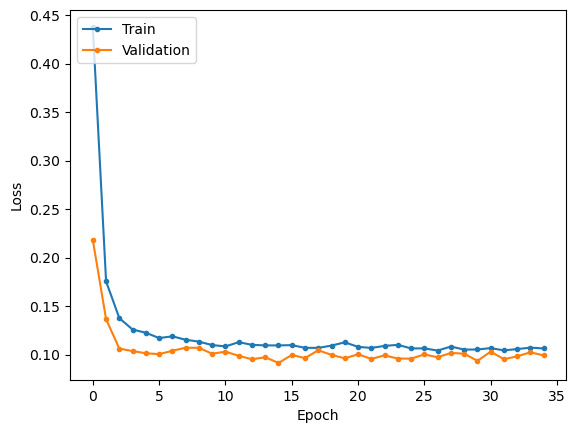

In [265]:
# Define the models dictionary
models = {
    'ANN': build_ann_model,
    'RNN': build_rnn_model, 
    'GRU': build_gru_model,
    'LSTM': build_lstm_model,
}

results = train_and_evaluate(models, epochs = 100, batch_size=32)

In [266]:
results

{'ANN': {'model': <keras.engine.sequential.Sequential at 0x23841f27190>,
  'history': <keras.callbacks.History at 0x2383b5d39d0>,
  'evaluation': [0.0649610385298729, 0.1467103809118271],
  'predictions': array([[-0.92925644],
         [-0.9296465 ],
         [-0.73260903],
         ...,
         [-0.91456366],
         [-0.87624204],
         [-0.8185335 ]], dtype=float32),
  'metrics': {'MAE': 0.14671035249678174,
   'MSE': 0.06496104056887093,
   'RMSE': 0.254874558496667,
   'MAPE': 0.5799620506348979,
   'R_squared': 0.9454928007437362}},
 'RNN': {'model': <keras.engine.sequential.Sequential at 0x238362207f0>,
  'history': <keras.callbacks.History at 0x23842497970>,
  'evaluation': [0.06536655128002167, 0.14424258470535278],
  'predictions': array([[-0.96991736],
         [-0.9624103 ],
         [-0.74421155],
         ...,
         [-0.9480732 ],
         [-0.9026565 ],
         [-0.8405981 ]], dtype=float32),
  'metrics': {'MAE': 0.14424256309510244,
   'MSE': 0.0653665284967004

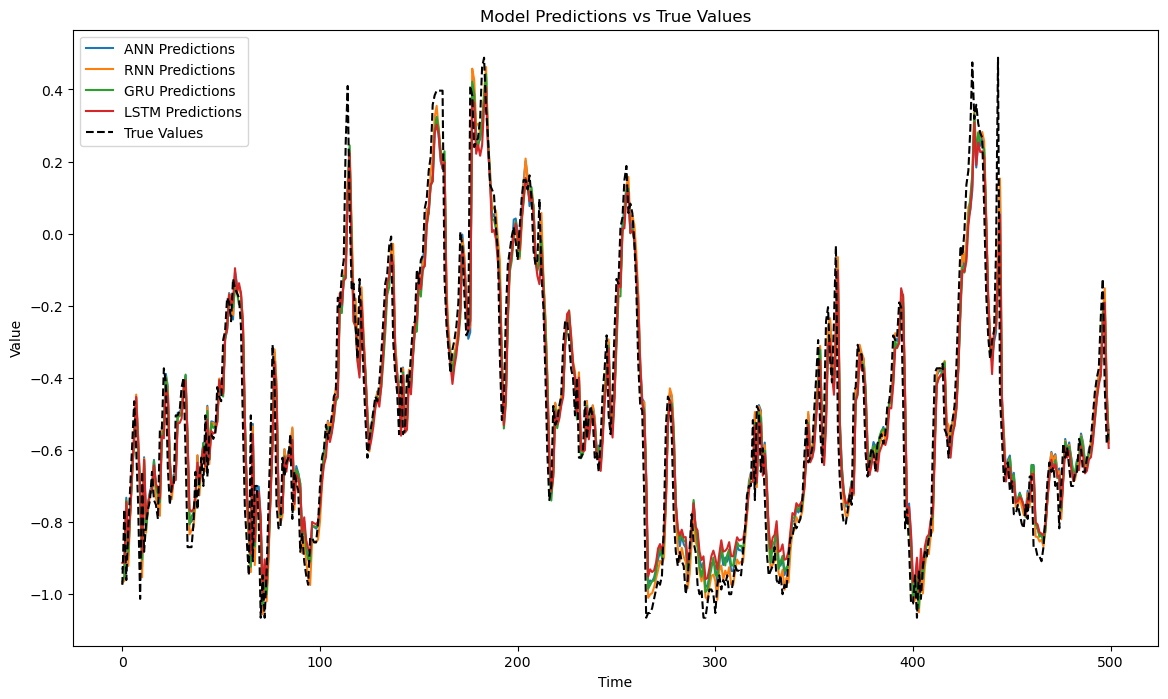

In [267]:
plot_predictions(results, y_test_pm25)

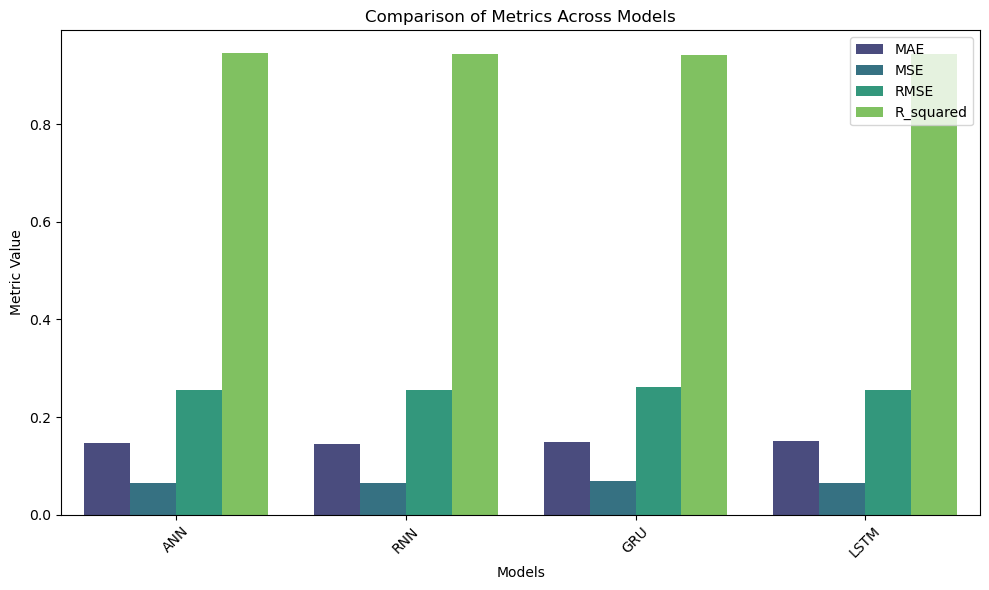

In [268]:
models = list(results.keys())
metrics = list(results[models[0]]['metrics'].keys())

data_plot = {metric: [results[model]['metrics'][metric] for model in models] for metric in metrics}

# Convert data to DataFrame
df_plot = pd.DataFrame(data_plot, index=models)

# Melt the DataFrame to 'long' format for seaborn
df_melted = pd.melt(df_plot.reset_index(), id_vars=['index'], value_vars=['MAE', 'MSE', 'RMSE', 'R_squared'],
                    var_name='Metric', value_name='Value')

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='Value', hue='Metric', data=df_melted, palette='viridis')
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Comparison of Metrics Across Models')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("models_metrics_comparison_hourly.pdf")
plt.show()

In [269]:
results['ANN']['metrics']

{'MAE': 0.14671035249678174,
 'MSE': 0.06496104056887093,
 'RMSE': 0.254874558496667,
 'MAPE': 0.5799620506348979,
 'R_squared': 0.9454928007437362}

In [270]:
results['RNN']['metrics']

{'MAE': 0.14424256309510244,
 'MSE': 0.06536652849670041,
 'RMSE': 0.25566878670792104,
 'MAPE': 0.5984768999527812,
 'R_squared': 0.9451525658724247}

In [271]:
results['GRU']['metrics']

{'MAE': 0.14852528029588064,
 'MSE': 0.06816783794444053,
 'RMSE': 0.2610897124446701,
 'MAPE': 0.590394378846654,
 'R_squared': 0.9428020565377637}

In [272]:
results['LSTM']['metrics']

{'MAE': 0.15078497895338294,
 'MSE': 0.0656675379887975,
 'RMSE': 0.2562567813518259,
 'MAPE': 0.5856324887707115,
 'R_squared': 0.9448999962673186}

### K-Fold Cross Validation

In [273]:
# Define number of splits (or number of folds)
n_splits = 5

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize list to store performance metrics
mse_scores = []
mae_scores = []
rmse_scores = []
r2_scores = []
mape_scores = []

# Iterate through each split
for train_index, test_index in tscv.split(df):
    
    # Split data into train and test sets
    print(len(train_index), len(test_index))
    
    train_df = features_pm25.iloc[train_index, :-1]
    test_df = features_pm25.iloc[test_index, :-1]
    
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    train_df['wd'] = features_pm25.iloc[train_index, -1]
    test_df['wd'] = features_pm25.iloc[test_index, -1]
    
    
    X_train, y_train = create_sequences(np.array(train_df), SEQ_LENGTH)
    X_test, y_test = create_sequences(np.array(test_df), SEQ_LENGTH)
    
    ann_model_cv = build_ann_model(X_train.shape[1:])
    
    ann_model_cv.fit(X_train, y_train, epochs=100, batch_size=32,shuffle=False)

    # Make predictions on the test data
    y_pred_cv = ann_model_cv.predict(X_test)
    
    # Calculate Metrics
    mse = mean_squared_error(y_test, y_pred_cv)
    mae = mean_absolute_error(y_test, y_pred_cv)
    r2 = r2_score(y_test, y_pred_cv)
    mape = mean_absolute_percentage_error(y_test, y_pred_cv)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_cv))
    
    # Append metrics to corresponding metric list
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

5844 5844
Epoch 1/100
183/183 [==============================] - 1s 2ms/step - loss: 2.0938 - mae: 1.0635
Epoch 2/100
183/183 [==============================] - 0s 3ms/step - loss: 1.2653 - mae: 0.7932
Epoch 3/100
183/183 [==============================] - 0s 2ms/step - loss: 0.8341 - mae: 0.6126
Epoch 4/100
183/183 [==============================] - 0s 2ms/step - loss: 0.6498 - mae: 0.5265
Epoch 5/100
183/183 [==============================] - 0s 2ms/step - loss: 0.5499 - mae: 0.4816
Epoch 6/100
183/183 [==============================] - 0s 2ms/step - loss: 0.4837 - mae: 0.4485
Epoch 7/100
183/183 [==============================] - 0s 2ms/step - loss: 0.4326 - mae: 0.4257
Epoch 8/100
183/183 [==============================] - 0s 2ms/step - loss: 0.4017 - mae: 0.4089
Epoch 9/100
183/183 [==============================] - 0s 2ms/step - loss: 0.3606 - mae: 0.3987
Epoch 10/100
183/183 [==============================] - 0s 3ms/step - loss: 0.3310 - mae: 0.3729
Epoch 11/100
183/183 [=======

Epoch 69/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1226 - mae: 0.2181
Epoch 70/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1406 - mae: 0.2215
Epoch 71/100
366/366 [==============================] - 1s 2ms/step - loss: 0.1188 - mae: 0.2177
Epoch 72/100
366/366 [==============================] - 1s 2ms/step - loss: 0.1271 - mae: 0.2208
Epoch 73/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1310 - mae: 0.2218
Epoch 74/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1263 - mae: 0.2192
Epoch 75/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1312 - mae: 0.2236
Epoch 76/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1353 - mae: 0.2236
Epoch 77/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1357 - mae: 0.2258
Epoch 78/100
366/366 [==============================] - 1s 2ms/step - loss: 0.1300 - mae: 0.2225
Epoch 79/100
366/366 [========

Epoch 36/100
731/731 [==============================] - 2s 3ms/step - loss: 0.1131 - mae: 0.2087
Epoch 37/100
731/731 [==============================] - 2s 3ms/step - loss: 0.1126 - mae: 0.2075
Epoch 38/100
731/731 [==============================] - 2s 3ms/step - loss: 0.1143 - mae: 0.2080
Epoch 39/100
731/731 [==============================] - 2s 3ms/step - loss: 0.1124 - mae: 0.2077
Epoch 40/100
731/731 [==============================] - 2s 2ms/step - loss: 0.1138 - mae: 0.2073
Epoch 41/100
731/731 [==============================] - 2s 2ms/step - loss: 0.1108 - mae: 0.2071
Epoch 42/100
731/731 [==============================] - 2s 3ms/step - loss: 0.1122 - mae: 0.2071
Epoch 43/100
731/731 [==============================] - 2s 2ms/step - loss: 0.1099 - mae: 0.2064
Epoch 44/100
731/731 [==============================] - 2s 3ms/step - loss: 0.1057 - mae: 0.2050
Epoch 45/100
731/731 [==============================] - 2s 2ms/step - loss: 0.1123 - mae: 0.2071
Epoch 46/100
731/731 [========

In [274]:
mse_scores

[0.1022152769481802,
 0.061005981709345375,
 0.05243103415355848,
 0.09983344610890978,
 0.06380773756144464]

In [275]:
np.mean(mse_scores)

0.07585869529628769

In [276]:
mae_scores

[0.18651680698962728,
 0.14532776978268788,
 0.15773711642702742,
 0.1559821971405963,
 0.1444611578844563]

In [277]:
np.mean(mae_scores)

0.158005009644879

In [278]:
rmse_scores

[0.31971123994658085,
 0.24699389002431898,
 0.22897823947606566,
 0.3159643114481599,
 0.2526019349914894]

In [279]:
np.mean(rmse_scores)

0.272849923177323

In [280]:
r2_scores

[0.9257988832890274,
 0.9429817998782851,
 0.9137582255724934,
 0.938893549643923,
 0.9477203602959456]

In [ ]:
np.mean(r2_scores)

In [ ]:
mape_scores

In [ ]:
np.mean(mape_scores)